# Assignment 3 - Project: Multi-class Text Classification using Transformers

### Richard El Chaar

# Introduction

This project tackles the challenge of multi-class text classification using the 20 Newsgroups dataset. The primary goal is to leverage the power of pre-trained transformer models, fine-tune them effectively, and rigorously evaluate their performance, interpretability, and deployability. This initial section details the crucial first steps: setting up the computational environment and performing comprehensive data preprocessing and augmentation. These steps are foundational for building robust and reliable classification models.

# 0. Environment Setup

The first step involved preparing the necessary software environment within the Google Colab notebook.

* **Library Installation:** A specific set of Python libraries was installed using `pip`. Key libraries included the Hugging Face suite (`transformers`, `datasets`, `evaluate`, `accelerate`) for model access and training, `scikit-learn` for data splitting and standard evaluation metrics, `nltk` for text preprocessing tasks like stopword removal and stemming, `matplotlib` and `seaborn` for visualization, and `lime` and `shap` for later model explainability analysis. `tensorboard` was included for monitoring training.
* **NLTK Resource Download:** Specific NLTK data packages (`stopwords`, `wordnet`, `punkt`, taggers) were downloaded to ensure availability for preprocessing steps like stopword removal and synonym lookup for augmentation.
* **Hardware Check:** The environment checks for GPU availability (`torch.cuda.is_available()`) and sets the computation `device` accordingly. Utilizing a GPU significantly accelerates transformer model training, and the execution confirmed a `cuda` device was available.
* **Output Directory:** A base directory (`/content/transformer_project/`) was created to systematically store model checkpoints, logs, and evaluation outputs generated during the project.

# 1. Data Preprocessing

This section focuses on preparing the 20 Newsgroups dataset for the transformer models.

* **Dataset Loading:** The `SetFit/20_newsgroups` version of the dataset was loaded using the `datasets.load_dataset` function from the Hugging Face Hub.
* **Label Handling:**
    * The 20 unique newsgroup names were extracted and sorted alphabetically to serve as class labels.
    * Mappings between integer indices and string labels (`id2label`, `label2id`) were created, which are essential for configuring the Hugging Face models and interpreting their outputs.
    * The dataset's `labels` column was explicitly cast to the `ClassLabel` type using the extracted names for better integration with the library's features.
* **Initial Data Combination:** The standard `train` and `test` splits provided within the loaded dataset were combined into a single corpus. This allowed for the creation of custom train, validation, and test sets with desired proportions and stratification, rather than relying solely on the original splits.
* **Preprocessing Pipeline:** A custom function, `preprocess_text`, was defined and applied to clean each document:
    * *Header/Quote Removal:* Lines likely containing email headers or quoted text from previous messages were filtered out.
    * *Noise Removal:* Email addresses and URLs were removed using regular expressions.
    * *Normalization:* Text was converted to lowercase. Non-alphanumeric characters were removed and replaced by spaces, and excess whitespace was collapsed.
    * *Stopword Removal:* Common English stopwords were removed using the standard NLTK list.
    * *Stemming:* Porter stemming was applied to reduce words to their root form (e.g., "classification", "classify" -> "classifi").
    * *Length Filtering:* Very short character sequences (length 1) resulting from the previous steps were discarded.
    * *Rationale:* This sequence of steps aims to standardize the text, reduce noise from metadata and irrelevant characters, decrease the effective vocabulary size, and normalize word forms, potentially improving model focus and performance.
* **Data Splitting:**
    * The fully preprocessed dataset was divided into training (70%), validation (15%), and test (15%) sets using `sklearn.model_selection.train_test_split`.
    * **Stratification** was employed during both splitting stages (test split first, then validation split from the remainder) based on the class labels. This ensures that the distribution of newsgroup classes is preserved across all three sets, which is critical for reliable model training and evaluation in multi-class scenarios.
    * A fixed `RANDOM_STATE` (42) was used to ensure the splitting process is reproducible.
* **Dataset Formatting:** The final split data arrays were converted into Hugging Face `Dataset` objects and organized within a `DatasetDict` named `proc_ds` for seamless use with the `Trainer` API.
* **Data Augmentation (Synonym Replacement):**
    * *Goal:* To synthetically increase the size and diversity of the training dataset, potentially enhancing model generalization and robustness.
    * *Method:* WordNet-based synonym replacement was chosen. A random 25% (`AUG_FRACT`) of the initial training samples were selected for augmentation. Within each selected sample, approximately 10% (`aug_frac`) of the words possessing synonyms in WordNet were randomly substituted with one of their synonyms.
    * *Implementation:* A helper function `get_synonyms` retrieved synonyms from WordNet, and `synonym_replacement` performed the stochastic replacement. Only samples where the text was actually altered by the process were kept and added to the training set.
    * The resulting augmented samples were concatenated with the original training set, increasing the training set size from 13192 to 16369 samples. The final combined training set was shuffled.

This comprehensive setup and preprocessing phase resulted in cleaned, stratified, and augmented datasets, optimized for input into the transformer models for the subsequent fine-tuning and evaluation stages.

In [2]:
# ## 0. Setup Environment
# Ensure you're using a GPU runtime for faster training: Runtime -> Change runtime type -> GPU

!pip install transformers[torch] datasets evaluate accelerate scikit-learn nltk nlpaug shap lime tensorboard matplotlib seaborn --quiet

import torch
import numpy as np
import pandas as pd
import nltk
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from tqdm.auto import tqdm

# Download required NLTK resources
nltk_packages = [
    'stopwords', 'wordnet', 'punkt',
    'averaged_perceptron_tagger', 'maxent_treebank_pos_tagger'
]
print("Ensuring NLTK resources are downloaded...")
for pkg in nltk_packages:
    nltk.download(pkg, quiet=True)
print("NLTK resource check complete.")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Output dir
output_dir_base = "/content/transformer_project/"
os.makedirs(output_dir_base, exist_ok=True)

# ## 1. Data Preprocessing
# a) Load and preprocess 20 Newsgroups dataset
# b) Stratified split
# c) Data augmentation

# Configuration
DATASET_NAME = "SetFit/20_newsgroups"
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.15  # Relative to the original dataset size
RANDOM_STATE = 42

# Load dataset
print(f"Loading dataset: {DATASET_NAME}")
raw_datasets = load_dataset(DATASET_NAME, trust_remote_code=True)

# Extract and map labels
tag_names = raw_datasets['train'].unique('label_text')
tag_names = sorted(tag_names)
num_labels = len(tag_names)
id2label = {i: name for i, name in enumerate(tag_names)}
label2id = {name: i for i, name in enumerate(tag_names)}
print(f"Classes ({num_labels}): {tag_names}")

# Cast and rename label column
raw_datasets = raw_datasets.cast_column('label', ClassLabel(names=tag_names))
raw_datasets = raw_datasets.rename_column('label', 'labels')

# Combine train/test for custom split
all_texts = raw_datasets['train']['text'] + raw_datasets['test']['text']
all_labels = raw_datasets['train']['labels'] + raw_datasets['test']['labels']

# Preprocessing function
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    lines = text.split('\n')
    cleaned = [l for l in lines if not l.startswith(('From:','Subject:','Organization:','Lines:','>','|')) and l.strip()]
    txt = ' '.join(cleaned)
    txt = re.sub(r'\S+@\S+', ' ', txt)
    txt = re.sub(r'http\S+', ' ', txt)
    txt = re.sub(r'\W+', ' ', txt).lower()
    txt = re.sub(r'\s+', ' ', txt).strip()
    words = txt.split()
    processed = [stemmer.stem(w) for w in words if w not in stop_words and len(w) > 1]
    return ' '.join(processed)

print("Applying preprocessing...")
processed_texts = [preprocess_text(t) for t in tqdm(all_texts)]
print("Done preprocessing.")

# Stratified splits
t_train_val, t_test, l_train_val, l_test = train_test_split(
    processed_texts, all_labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=all_labels
)
rel_val_size = VALIDATION_SIZE / (1.0 - TEST_SIZE)
t_train, t_val, l_train, l_val = train_test_split(
    t_train_val, l_train_val,
    test_size=rel_val_size,
    random_state=RANDOM_STATE,
    stratify=l_train_val
)
print(f"Train size: {len(t_train)}")
print(f"Validation size: {len(t_val)}")
print(f"Test size: {len(t_test)}")

# Build HF Datasets
d_train = Dataset.from_dict({'text': t_train, 'labels': l_train})
d_val   = Dataset.from_dict({'text': t_val,   'labels': l_val})
d_test  = Dataset.from_dict({'text': t_test,  'labels': l_test})
proc_ds = DatasetDict({'train': d_train, 'validation': d_val, 'test': d_test})
proc_ds = proc_ds.cast_column('labels', ClassLabel(names=tag_names))
print(proc_ds)

# --- Data Augmentation: Custom WordNet Synonym Replacement ---

def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            name = lemma.name().replace('_', ' ')
            if name.lower() != word.lower():
                syns.add(name)
    return list(syns)


def synonym_replacement(text, aug_frac=0.1):
    words = text.split()
    num_to_replace = max(1, int(len(words) * aug_frac))
    candidates = [w for w in words if get_synonyms(w)]
    if not candidates:
        return text
    random.shuffle(candidates)
    replaced = 0
    new_words = words.copy()
    for w in candidates:
        syns = get_synonyms(w)
        if syns:
            choice = random.choice(syns)
            new_words = [choice if x == w else x for x in new_words]
            replaced += 1
        if replaced >= num_to_replace:
            break
    return ' '.join(new_words)

AUG_FRACT = 0.25
n_orig = len(proc_ds['train'])
n_aug  = int(n_orig * AUG_FRACT)
# Ensure indices are Python ints, not numpy.int64
i_idxs = [int(i) for i in np.random.choice(n_orig, n_aug, replace=False)]
aug_texts, aug_labels = [], []
for idx in i_idxs:
    orig = proc_ds['train'][idx]['text']
    lbl  = proc_ds['train'][idx]['labels']
    aug  = synonym_replacement(orig, aug_frac=0.1)
    if aug != orig:
        aug_texts.append(aug)
        aug_labels.append(lbl)

if aug_texts:
    from datasets import concatenate_datasets
    aug_ds = Dataset.from_dict({'text': aug_texts, 'labels': aug_labels})
    aug_ds = aug_ds.cast_column('labels', ClassLabel(names=tag_names))
    proc_ds['train'] = concatenate_datasets([proc_ds['train'], aug_ds]).shuffle(seed=RANDOM_STATE)
    print(f"Augmentation complete. New train size: {len(proc_ds['train'])}")
else:
    print("No augmentations applied.")
# --- End of Augmentation Section ---

# Continue with tokenization, model setup, training, and evaluation below...


Ensuring NLTK resources are downloaded...
NLTK resource check complete.
Using device: cuda
Loading dataset: SetFit/20_newsgroups


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/8.91M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11314 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7532 [00:00<?, ? examples/s]

Classes (20): ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Casting the dataset:   0%|          | 0/11314 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7532 [00:00<?, ? examples/s]

Applying preprocessing...


  0%|          | 0/18846 [00:00<?, ?it/s]

Done preprocessing.
Train size: 13192
Validation size: 2827
Test size: 2827


Casting the dataset:   0%|          | 0/13192 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2827 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2827 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 13192
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2827
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2827
    })
})


Casting the dataset:   0%|          | 0/3177 [00:00<?, ? examples/s]

Augmentation complete. New train size: 16369


# 2. Implement and Fine-Tune Transformer Models

This section outlines the core modeling experiments, starting with the configuration of essential parameters and helper functions, followed by a comparative analysis of different pre-trained transformer architectures to select a base model for further optimization.

### 2.0 Setup: Constants, Helpers, and Validation

To ensure reproducibility and configure the training process, key constants and helper functions were established:

* **Core Parameters:** A maximum sequence length (`MAX_SEQ_LENGTH`) of 128 tokens was set to balance context capture and computational efficiency. A standard initial learning rate (`BASE_LEARNING_RATE`) of 5e-5 and weight decay (`BASE_WEIGHT_DECAY`) of 0.01 were chosen, common defaults for fine-tuning with AdamW. A batch size (`BASE_BATCH_SIZE`) of 32 was used. A fixed number of epochs (`BASE_NUM_EPOCHS_BASELINE` = 3) was set for the initial model comparison. Parameters for early stopping (`patience=2`, `threshold=0.01`) were also defined for later tuning stages.
* **Helper Functions:**
    * `compute_metrics`: Calculated Accuracy and weighted Precision, Recall, F1-score during evaluation, suitable for this multi-class task.
    * `tokenize_function`: Applied model-specific tokenization, handling padding and truncation to `MAX_SEQ_LENGTH`.
* **Label Sanity Check:** A check confirmed that all dataset labels were correctly mapped within the expected range [0, 19], ensuring validity before training. The output confirmed "Labels seem OK".
* **Environment:** GPU acceleration (`cuda`) was confirmed and utilized. An output directory (`./output`) was established.

### 2a. Base Model Comparison

* **Objective:** To evaluate and compare the out-of-the-box fine-tuning performance of three distinct pre-trained transformer architectures on the 20 Newsgroups classification task, using identical, minimal fine-tuning settings. This helps identify the most suitable foundation for deeper optimization.

* **Models Compared & Architectural Differences:**
    1.  **BERT (`bert-base-uncased`):** The foundational Bidirectional Encoder Representations from Transformers model (~110M parameters). It uses WordPiece tokenization and was pre-trained on Masked Language Modeling (MLM) and Next Sentence Prediction (NSP) tasks. Its bidirectional nature allows it to learn context from both left and right of a token.
    2.  **DistilBERT (`distilbert-base-uncased`):** A distilled version of BERT (~66M parameters). It leverages knowledge distillation during pre-training to create a smaller, faster model designed to retain a large percentage (often >95%) of BERT's performance while being computationally less expensive. It typically shares the same WordPiece tokenizer as the BERT model it was distilled from but lacks token-type embeddings and the NSP pooler layer.
    3.  **RoBERTa (`roberta-base`):** A Robustly Optimized BERT Pretraining Approach (~125M parameters). It modifies BERT's pre-training by using dynamic masking (instead of static), removing the NSP task (found to be less effective), training with much larger batch sizes, and using a larger byte-level BPE tokenizer. These changes often lead to improved performance on downstream tasks compared to BERT, particularly on GLUE benchmarks.

* **Methodology:**
    * Each model was fine-tuned for **exactly 3 epochs** using the augmented training set (16369 samples) and evaluated on the validation set (2827 samples).
    * Consistent hyperparameters were used: Learning Rate = 5e-5, Batch Size = 32, AdamW optimizer (via `Trainer`), Weight Decay = 0.01, Mixed Precision (`fp16=True`) on GPU.
    * **No early stopping** was used in this specific phase to ensure a direct comparison based on performance after a fixed number of epochs (3). Each model used its specific tokenizer.

* **Results and Analysis:**
    * The fine-tuning process completed for all models. DistilBERT demonstrated significantly faster training (55s) compared to BERT (95s) and RoBERTa (101s), highlighting its efficiency advantage.
    * The validation metrics after 3 epochs were:

| Model      | Identifier              | eval_f1  | eval_accuracy | eval_loss | training_time | final_epoch |
| :--------- | :---------------------- | :------- | :------------ | :-------- | :------------ | :---------- |
| BERT       | bert-base-uncased       | 0.714555 | 0.715600      | 0.967967  | 94.7348       | 3           |
| DistilBERT | distilbert-base-uncased | 0.703832 | 0.708879      | 0.988106  | 55.4856       | 3           |
| RoBERTa    | roberta-base            | 0.689509 | 0.692961      | 1.03057   | 100.888       | 3           |



* **Analysis:** In this 3-epoch baseline comparison, BERT (`bert-base-uncased`) achieved the highest validation F1 score (0.7146) and accuracy (0.7156). DistilBERT performed commendably close (F1 0.7038, approx. 98.5% of BERT's F1 score) while being significantly faster, confirming its value as an efficient alternative. Surprisingly, RoBERTa yielded slightly lower performance (F1 0.6895) than BERT in this short run. While often outperforming BERT on benchmarks, RoBERTa's optimized pre-training might require more extensive fine-tuning (more epochs or different hyperparameters) to fully realize its potential on certain downstream tasks compared to BERT's robustness in shorter tuning scenarios.

* **Model Selection:** Based on achieving the highest validation F1 score under these identical, fixed-epoch conditions, **BERT (`bert-base-uncased`)** was selected as the most promising base model for the subsequent, more detailed tuning steps involving dropout and classification head architectures.

In [3]:
import numpy as np
import os
import gc
import torch
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Assuming your proc_ds, label2id, id2label are already loaded and prepared
# from the previous steps (Data Preprocessing, Augmentation etc.)
# Ensure label2id and id2label correspond to the 20 newsgroups.

# ==============================================================
# Define Constants and Helper Functions
# ==============================================================
MAX_SEQ_LENGTH = 128
BASE_LEARNING_RATE = 5e-5
BASE_BATCH_SIZE = 32 # You might need to decrease this for larger models like RoBERTa
BASE_NUM_EPOCHS_BASELINE = 3 # Epochs for baseline comparison
BASE_NUM_EPOCHS_TUNING = 3 # Epochs for dropout tuning
BASE_WEIGHT_DECAY = 0.01
early_stopping_patience = 2
early_stopping_threshold = 0.01
output_dir_base = './output'
os.makedirs(output_dir_base, exist_ok=True) # Ensure base output dir exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def compute_metrics(eval_pred):
    """Computes accuracy, F1, precision, and recall for evaluation."""
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    # Use weighted average for multi-class case (good default)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define tokenize_function
def tokenize_function(examples, tokenizer, max_length):
    # Ensure 'text' column exists and handle potential errors if needed
    if 'text' not in examples:
        raise ValueError("Input examples must contain a 'text' field.")
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

# ==============================================================
# Sanity Check Labels (Crucial before starting)
# ==============================================================
print("--- Checking label range in proc_ds before starting ---")
if 'label2id' not in globals() or not isinstance(label2id, dict) or not label2id:
     raise NameError("Error: label2id mapping not found or invalid. Please ensure data preprocessing is complete.")
if 'proc_ds' not in globals():
     raise NameError("Error: proc_ds not found. Please ensure data preprocessing is complete.")

num_labels_expected = len(label2id)
print(f"Expected num_labels: {num_labels_expected}")
if num_labels_expected != 20:
    print(f"WARNING: Expected 20 labels for 20 Newsgroups, but found {num_labels_expected}. Check label2id.")
print(f"Label mapping (first 5): {list(label2id.items())[:5]}")

try:
    # Check label ranges across all splits in proc_ds
    all_labels = []
    for split in proc_ds.keys():
        if 'labels' in proc_ds[split].features:
            split_labels = proc_ds[split]['labels']
            min_label = min(split_labels)
            max_label = max(split_labels)
            print(f"{split.capitalize()} labels: min={min_label}, max={max_label}")
            if min_label < 0 or max_label >= num_labels_expected:
                 print(f"\n!!! FATAL ERROR: {split.capitalize()} labels OUTSIDE expected range [0, {num_labels_expected-1}] !!!")
                 invalid_labels = {l for l in split_labels if not (0 <= l < num_labels_expected)}
                 print(f"Invalid labels found in {split}: {invalid_labels}\n")
                 raise ValueError(f"Invalid labels found in {split} split. Cannot proceed.")
            all_labels.extend(split_labels)
        else:
            print(f"Warning: 'labels' column not found in split '{split}'.")

    if not all_labels:
         raise ValueError("No labels found in any dataset split.")

except Exception as e:
    print(f"Error during label check: {e}")
    raise # Re-raise the exception to stop execution if labels are bad
print("--- Finished checking label range. Labels seem OK. ---\n")


# ==============================================================
# Task 2a: Base Model Comparison
# ==============================================================
print("\n--- Starting Task 2a: Base Model Comparison ---")

models_to_compare = {
    # Name: HuggingFace Identifier
    'BERT': 'bert-base-uncased',
    'DistilBERT': 'distilbert-base-uncased',
    'RoBERTa': 'roberta-base'
    # Add 'albert-base-v2' or others if your compute allows
}
baseline_results = {}

# --- Environment variable for potentially better error messages ---
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # Uncomment for debugging CUDA errors

for model_short_name, model_identifier in models_to_compare.items():
    print(f"\n--- Comparing Model: {model_short_name} ({model_identifier}) ---")
    run_output_dir = os.path.join(output_dir_base, f"task2a_baseline_{model_short_name}")
    tokenized_datasets = None # Ensure it's reset or defined in scope
    trainer = None
    model = None
    config = None
    tokenizer = None
    data_collator = None

    try:
        # 1. Load Tokenizer specific to this model
        print(f"Loading tokenizer for {model_identifier}...")
        tokenizer = AutoTokenizer.from_pretrained(model_identifier)
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

        # 2. Tokenize dataset with this specific tokenizer
        print(f"Tokenizing dataset for {model_short_name}...")
        # Use with_indices=True if you need original indices later
        tokenized_datasets = proc_ds.map(
            lambda examples: tokenize_function(examples, tokenizer, max_length=MAX_SEQ_LENGTH),
            batched=True,
            remove_columns=['text'] # Remove original text column after tokenization
        )
        # Ensure datasets are in torch format
        tokenized_datasets.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
        print(f"Sample tokenized input: {tokenized_datasets['train'][0]['input_ids'][:20]}...") # Check sample

        # 3. Load Config (use default dropout from pretrained for baseline)
        print(f"Loading configuration for {model_identifier}...")
        config = AutoConfig.from_pretrained(
            model_identifier,
            num_labels=num_labels_expected,
            id2label=id2label,
            label2id=label2id,
        )

        # 4. Load Model
        print(f"Loading model {model_identifier}...")
        model = AutoModelForSequenceClassification.from_pretrained(
            model_identifier,
            config=config
        )
        model.to(device)
        print(f"Model loaded to {device}")

        # 5. Basic Training Arguments for Baseline Comparison
        # Adjust batch size if needed based on model size and GPU memory
        current_batch_size = BASE_BATCH_SIZE
        if "roberta" in model_identifier.lower(): # Example adjustment
             # current_batch_size = max(4, BASE_BATCH_SIZE // 2) # RoBERTa might need smaller batch size
             print(f"Note: Consider adjusting batch size for {model_short_name} if memory issues occur.")

        training_args = TrainingArguments(
            output_dir=run_output_dir,
            eval_strategy="epoch",
            save_strategy="epoch", # Save checkpoints each epoch
            learning_rate=BASE_LEARNING_RATE,
            per_device_train_batch_size=current_batch_size,
            per_device_eval_batch_size=current_batch_size * 2,
            num_train_epochs=BASE_NUM_EPOCHS_BASELINE, # Fixed epochs
            weight_decay=BASE_WEIGHT_DECAY,
            logging_dir=os.path.join(run_output_dir, 'logs'),
            logging_strategy="epoch", # Log metrics at the end of each epoch
            load_best_model_at_end=False, # Not strictly needed for baseline comparison run
            # metric_for_best_model="f1", # Only needed if load_best_model_at_end=True
            # greater_is_better=True,
            save_total_limit=1, # Keep only the last checkpoint for baseline
            fp16=torch.cuda.is_available(),
            report_to="none", # Disable default reporting unless needed (e.g., "tensorboard")
            # No early stopping for strict epoch-based comparison:
            # callbacks=[EarlyStoppingCallback(...)],
            seed=42 # Ensure reproducibility for comparison
        )

        # 6. Initialize Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )

        # 7. Train
        print(f"Starting baseline training for {model_short_name}...")
        train_result = trainer.train()
        print("Training finished.")

        # 8. Evaluate
        print(f"Evaluating {model_short_name} on validation set...")
        eval_results = trainer.evaluate()
        final_epoch = eval_results.get("epoch", BASE_NUM_EPOCHS_BASELINE) # Get actual epoch if training finished early
        print(f"Baseline Validation Results for {model_short_name} (Epoch {final_epoch}): {eval_results}")

        # 9. Store results
        baseline_results[model_short_name] = {
            "model_identifier": model_identifier,
            "eval_f1": eval_results.get("eval_f1", -1.0),
            "eval_accuracy": eval_results.get("eval_accuracy", -1.0),
            "eval_loss": eval_results.get("eval_loss", float('inf')),
            "training_time": train_result.metrics.get("train_runtime", 0),
            "final_epoch": final_epoch
         }

    except Exception as e:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"!!! Training/Evaluation FAILED for {model_short_name} ({model_identifier})")
        print(f"!!! Error: {e}")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        baseline_results[model_short_name] = {"status": "failed", "error": str(e)}

    finally:
        # 10. Cleanup Memory before next model iteration
        print(f"Cleaning up resources for {model_short_name}...")
        del model, trainer, config, tokenizer, tokenized_datasets, data_collator
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("Cleanup complete.")

# ==============================================================
# Summarize Task 2a Results and Select Best Model
# ==============================================================
print("\n--- Task 2a: Baseline Model Comparison Summary ---")
baseline_df = pd.DataFrame.from_dict(baseline_results, orient='index')
print(baseline_df.to_markdown(numalign="left", stralign="left")) # Print readable summary

# Select the best model based on validation F1 (handle potential failures)
valid_baseline_results = baseline_df[baseline_df['eval_f1'] > -1.0]
if not valid_baseline_results.empty:
    # Sort by F1 descending, then maybe accuracy descending as a tie-breaker
    valid_baseline_results = valid_baseline_results.sort_values(by=["eval_f1", "eval_accuracy"], ascending=False)
    best_model_short_name = valid_baseline_results.index[0]
    best_model_row = valid_baseline_results.iloc[0]
    SELECTED_MODEL_IDENTIFIER = best_model_row['model_identifier']
    print(f"\n---> Selected Best Baseline Model: '{best_model_short_name}' ({SELECTED_MODEL_IDENTIFIER})")
    print(f"---> Best F1: {best_model_row['eval_f1']:.4f}, Accuracy: {best_model_row['eval_accuracy']:.4f}")
else:
    print("\nError: No baseline models trained successfully. Falling back to default 'bert-base-uncased'.")
    SELECTED_MODEL_IDENTIFIER = 'bert-base-uncased' # Fallback
    print(f"Using fallback model: {SELECTED_MODEL_IDENTIFIER}")

Using device: cuda
--- Checking label range in proc_ds before starting ---
Expected num_labels: 20
Label mapping (first 5): [('alt.atheism', 0), ('comp.graphics', 1), ('comp.os.ms-windows.misc', 2), ('comp.sys.ibm.pc.hardware', 3), ('comp.sys.mac.hardware', 4)]
Train labels: min=0, max=19
Validation labels: min=0, max=19
Test labels: min=0, max=19
--- Finished checking label range. Labels seem OK. ---


--- Starting Task 2a: Base Model Comparison ---

--- Comparing Model: BERT (bert-base-uncased) ---
Loading tokenizer for bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset for BERT...


Map:   0%|          | 0/16369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Sample tokenized input: tensor([  101, 10655,  2632,  9626,  2099,  2288,  2521,  3618, 12992,  2188,
         5127,  2380, 25818, 28921,  2416,  2698,  2188,  5127,  2448, 17012])...
Loading configuration for bert-base-uncased...
Loading model bert-base-uncased...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to cuda
Starting baseline training for BERT...


Training finished.
Evaluating BERT on validation set...


Baseline Validation Results for BERT (Epoch 3.0): {'eval_loss': 0.967966616153717, 'eval_accuracy': 0.7155995755217545, 'eval_f1': 0.7145548500412416, 'eval_precision': 0.7197414303562911, 'eval_recall': 0.7155995755217545, 'eval_runtime': 1.0436, 'eval_samples_per_second': 2708.864, 'eval_steps_per_second': 43.12, 'epoch': 3.0}
Cleaning up resources for BERT...
Cleanup complete.

--- Comparing Model: DistilBERT (distilbert-base-uncased) ---
Loading tokenizer for distilbert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset for DistilBERT...


Map:   0%|          | 0/16369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Sample tokenized input: tensor([  101, 10655,  2632,  9626,  2099,  2288,  2521,  3618, 12992,  2188,
         5127,  2380, 25818, 28921,  2416,  2698,  2188,  5127,  2448, 17012])...
Loading configuration for distilbert-base-uncased...
Loading model distilbert-base-uncased...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to cuda
Starting baseline training for DistilBERT...


Training finished.
Evaluating DistilBERT on validation set...


Baseline Validation Results for DistilBERT (Epoch 3.0): {'eval_loss': 0.9881057739257812, 'eval_accuracy': 0.7088786699681642, 'eval_f1': 0.7038322982042987, 'eval_precision': 0.7079094467459819, 'eval_recall': 0.7088786699681642, 'eval_runtime': 0.6825, 'eval_samples_per_second': 4141.92, 'eval_steps_per_second': 65.931, 'epoch': 3.0}
Cleaning up resources for DistilBERT...
Cleanup complete.

--- Comparing Model: RoBERTa (roberta-base) ---
Loading tokenizer for roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing dataset for RoBERTa...


Map:   0%|          | 0/16369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Sample tokenized input: tensor([    0,  3341, 10715,  1076,  1075,   271,   300,   444,  2388,  2501,
          184,  5299,  2221,   741, 27075,  2538,   411,   707,   184,  5299])...
Loading configuration for roberta-base...
Loading model roberta-base...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to cuda
Note: Consider adjusting batch size for RoBERTa if memory issues occur.
Starting baseline training for RoBERTa...


Training finished.
Evaluating RoBERTa on validation set...


Baseline Validation Results for RoBERTa (Epoch 3.0): {'eval_loss': 1.0305731296539307, 'eval_accuracy': 0.6929607357622922, 'eval_f1': 0.6895090586247277, 'eval_precision': 0.6945258358560795, 'eval_recall': 0.6929607357622922, 'eval_runtime': 1.0512, 'eval_samples_per_second': 2689.433, 'eval_steps_per_second': 42.81, 'epoch': 3.0}
Cleaning up resources for RoBERTa...
Cleanup complete.

--- Task 2a: Baseline Model Comparison Summary ---
|            | model_identifier        | eval_f1   | eval_accuracy   | eval_loss   | training_time   | final_epoch   |
|:-----------|:------------------------|:----------|:----------------|:------------|:----------------|:--------------|
| BERT       | bert-base-uncased       | 0.714555  | 0.7156          | 0.967967    | 94.7348         | 3             |
| DistilBERT | distilbert-base-uncased | 0.703832  | 0.708879        | 0.988106    | 55.4856         | 3             |
| RoBERTa    | roberta-base            | 0.689509  | 0.692961        | 1.03057    

### 2b. Dropout Tuning for Selected Base Model (BERT)

* **Objective:** Having selected BERT (`bert-base-uncased`) as the most promising base architecture in Task 2a, this step aimed to optimize its regularization by tuning the dropout rate. Dropout is a crucial regularization technique that randomly sets a fraction of neuron activations to zero during training, helping to prevent co-adaptation between neurons and improve model generalization to unseen data.

* **Methodology:**
    * **Model:** `bert-base-uncased`. The dataset was re-tokenized specifically for this model.
    * **Dropout Rates:** Three rates were systematically tested: `0.0` (effectively disabling dropout, serving as a control), `0.05`, and `0.1`. These rates were applied to both the hidden layers (`hidden_dropout_prob`) and the attention mechanisms (`attention_probs_dropout_prob`) in the model's configuration.
    * **Training Setup:**
        * Each trial started fresh from the original `bert-base-uncased` pre-trained weights.
        * Consistent hyperparameters were used: Learning Rate = 5e-5, Batch Size = 32, AdamW optimizer, Weight Decay = 0.01, Max Epochs = 3.
        * **Early Stopping:** `EarlyStoppingCallback` monitored the validation `f1` score (patience=2, threshold=0.01).
        * **Best Model Saving:** `load_best_model_at_end=True` ensured the best performing checkpoint based on validation F1 was used for final evaluation of each dropout rate.
        * Mixed precision (`fp16=True`) was used.

* **Execution & Convergence Analysis:**
    * Training logs showed consistent decreases in training loss across epochs for all rates.
    * Validation loss typically decreased from epoch 1 to 2, then slightly increased or plateaued by epoch 3 (e.g., Dropout 0.05: 1.07 -> 0.96 -> 0.97), suggesting peak validation performance around epoch 2 or 3 and validating the use of early stopping (`load_best_model_at_end`).

* **Results Summary & Selection:**
    
    * The best validation metrics achieved during each run were summarized:

    * **Analysis:**
        * **F1 Score (Weighted):** This was the primary metric for selection. The dropout rate of **0.05 yielded the highest F1 score (0.7199)**, indicating the best balance between precision and recall according to this metric, weighted by class support. It slightly outperformed the 0.0 dropout rate (0.7193) and was noticeably better than the 0.1 rate (0.7105).
        * **Accuracy:** Accuracy measures the overall proportion of correctly classified instances. The trend mirrored the F1 score, with the **0.05 dropout rate achieving the highest accuracy (0.7202)**, compared to 0.7184 (dropout 0.0) and 0.7142 (dropout 0.1). This reinforces that the 0.05 rate led to the most correct predictions overall.
        * **Precision (Weighted):** This metric reflects the proportion of positive predictions that were correct, averaged across classes (weighted by support). Interestingly, the **0.0 dropout rate had the marginally highest precision (0.7251)**, slightly better than 0.05 (0.7244). This *could* suggest that when the model without dropout made a positive prediction for a class, it was slightly more likely to be correct than the 0.05 model, but this came at the cost of slightly lower recall/F1/accuracy.
        * **Recall (Weighted):** This measures the proportion of actual positive instances that were correctly identified, averaged across classes (weighted by support). As expected when using weighted averaging, the recall values directly tracked the accuracy values, with **0.05 dropout achieving the highest recall (0.7202)**.
        * **Validation Loss:** This represents the model's cross-entropy error on the validation set (lower is better). The **0.05 dropout rate achieved the lowest validation loss (0.9714)**, indicating it generalized slightly better and had less error on unseen data compared to dropout 0.0 (0.9930) and dropout 0.1 (0.9759).

    * **Selection:** Considering all metrics, the dropout rate of **0.05** presented the best overall profile. It achieved the highest F1 score (primary metric), highest accuracy, highest recall, and lowest validation loss, despite having marginally lower precision than the 0.0 dropout model. Therefore, `0.05` was selected as the optimal rate (`SELECTED_DROPOUT_RATE`). The corresponding best checkpoint (`BEST_MODEL_CHECKPOINT_TASK_2B = ./output/task2b_dropout_0.05_BERT/checkpoint-1536`) was saved for the next phase.


|              | eval_loss | eval_accuracy | eval_f1  | eval_precision | eval_recall | eval_runtime | eval_samples_per_second | eval_steps_per_second | epoch |
|:-------------|:----------|:--------------|:---------|:---------------|:------------|:-------------|:--------------------------|:------------------------|:------|
| dropout_0.05 | 0.971441  | 0.720198      | 0.719850 | 0.724415       | 0.720198    | 1.0399       | 2718.53                   | 43.273                  | 3.0   |
| dropout_0    | 0.992970  | 0.718429      | 0.719328 | 0.725118       | 0.718429    | 1.0695       | 2643.19                   | 42.074                  | 3.0   |
| dropout_0.1  | 0.975921  | 0.714185      | 0.710501 | 0.715247       | 0.714185    | 1.0847       | 2606.18                   | 41.485                  | 3.0   |

In [6]:
# ==============================================================
# Task 2b: Dropout Tuning for the Selected Best Model
# ==============================================================
print("\n" + "="*60)
print(f" Task 2b: Dropout Tuning for Selected Model: {SELECTED_MODEL_IDENTIFIER}")
print("="*60)



# --- Determine SELECTED_MODEL_SHORT_NAME based on SELECTED_MODEL_IDENTIFIER ---
print(f"\nMapping selected model identifier '{SELECTED_MODEL_IDENTIFIER}' to short name...")
model_name_map = {'bert': 'BERT', 'distilbert': 'DistilBERT', 'roberta': 'RoBERTa', 'albert': 'ALBERT'}
SELECTED_MODEL_SHORT_NAME = "Unknown" # Initialize

# Ensure SELECTED_MODEL_IDENTIFIER is a string path before calling os.path.basename
if isinstance(SELECTED_MODEL_IDENTIFIER, str):
    identifier_base_c = os.path.basename(SELECTED_MODEL_IDENTIFIER)
else:
    print(f"Warning: SELECTED_MODEL_IDENTIFIER is not a string path: {SELECTED_MODEL_IDENTIFIER}")
    identifier_base_c = ""

for key, val in model_name_map.items():
     if identifier_base_c and key in identifier_base_c.lower():
        SELECTED_MODEL_SHORT_NAME = val
        break

if SELECTED_MODEL_SHORT_NAME == "Unknown":
    # If mapping failed, try using the temporary short name from Task 2a results if available
    if 'best_model_short_name_task2a' in locals():
         SELECTED_MODEL_SHORT_NAME = best_model_short_name_task2a
         print(f"Warning: Could not map identifier basename. Using short name from Task 2a results: '{SELECTED_MODEL_SHORT_NAME}'")
    else:
         print(f"Warning: Could not map {SELECTED_MODEL_IDENTIFIER} to a short name (using map: {model_name_map}). Leaving as 'Unknown'.")
else:
     print(f"Mapped to short name: '{SELECTED_MODEL_SHORT_NAME}'")
# ***** END OF INSERTED BLOCK *****



# --- Define variables for this stage ---
BEST_MODEL_CHECKPOINT_TASK_2B = None # Will hold path to best checkpoint AFTER dropout tuning
SELECTED_DROPOUT_RATE = 0.1 # Default if tuning fails

# --- Reload tokenizer and tokenize data for the selected model ---
print(f"Reloading tokenizer and tokenizing data for {SELECTED_MODEL_IDENTIFIER}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(SELECTED_MODEL_IDENTIFIER)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    tokenized_datasets = proc_ds.map( # Re-tokenize using the selected model's tokenizer
        lambda exs: tokenize_function(exs, tokenizer, MAX_SEQ_LENGTH), batched=True, remove_columns=['text']
    )
    tokenized_datasets.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
    print("Tokenization complete for tuning phase.")
except Exception as e:
     print(f"Error tokenizing data for tuning phase: {e}")
     raise

# --- Dropout Tuning Setup ---
dropout_rates_to_try = [0, 0.05, 0.1] # Example rates, adjust as needed
tuning_results = {}
best_dropout_val_f1 = -1.0
best_dropout_rate_found = None # Temp var for finding best rate in loop
best_dropout_model_path_temp = None # Temp var for best path in loop

base_model_identifier_tuning = SELECTED_MODEL_IDENTIFIER

# --- Loop through dropout rates ---
for dropout_rate in dropout_rates_to_try:
    print(f"\n--- Tuning {base_model_identifier_tuning} with Dropout: {dropout_rate} ---")
    run_output_dir = os.path.join(output_dir_base, f"task2b_dropout_{dropout_rate}_{SELECTED_MODEL_SHORT_NAME}") # Use short name
    trainer = None; model = None; config = None # Reset

    try:
        print("Loading configuration and modifying dropout...")
        config = AutoConfig.from_pretrained(
            base_model_identifier_tuning, num_labels=num_labels_expected, id2label=id2label, label2id=label2id,
            hidden_dropout_prob=dropout_rate, attention_probs_dropout_prob=dropout_rate
        )
        if hasattr(config, 'classifier_dropout') and config.classifier_dropout is not None: config.classifier_dropout = dropout_rate
        elif hasattr(config, 'dropout'): config.dropout = dropout_rate

        print(f"Loading model {base_model_identifier_tuning}...")
        model = AutoModelForSequenceClassification.from_pretrained(base_model_identifier_tuning, config=config)
        model.to(device)

        training_args = TrainingArguments(
            output_dir=run_output_dir, eval_strategy="epoch", save_strategy="epoch",
            learning_rate=BASE_LEARNING_RATE, weight_decay=BASE_WEIGHT_DECAY,
            per_device_train_batch_size=BASE_BATCH_SIZE, # Assumes selected model fits BASE_BATCH_SIZE
            per_device_eval_batch_size=BASE_BATCH_SIZE * 2,
            num_train_epochs=BASE_NUM_EPOCHS_TUNING,
            logging_dir=os.path.join(run_output_dir, 'logs'), logging_strategy="steps", logging_steps=100,
            load_best_model_at_end=True, metric_for_best_model="f1", greater_is_better=True,
            save_total_limit=2, fp16=torch.cuda.is_available(), report_to="tensorboard", seed=RANDOM_STATE
        )

        trainer = Trainer(
            model=model, args=training_args, data_collator=data_collator,
            train_dataset=tokenized_datasets["train"], eval_dataset=tokenized_datasets["validation"],
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience, early_stopping_threshold=early_stopping_threshold)]
        )

        print(f"Starting tuning training with dropout {dropout_rate}...")
        trainer.train()
        print("Tuning training finished.")

        print("Evaluating best model checkpoint on validation set...")
        eval_results = trainer.evaluate()
        print(f"Validation Results for Dropout {dropout_rate}: {eval_results}")
        tuning_results[f"dropout_{dropout_rate}"] = eval_results

        current_val_f1 = eval_results.get("eval_f1", -1.0)
        if current_val_f1 > best_dropout_val_f1:
            best_dropout_val_f1 = current_val_f1
            best_dropout_rate_found = dropout_rate
            best_dropout_model_path_temp = trainer.state.best_model_checkpoint # Store path from this run
            print(f"*** New best dropout rate found: {dropout_rate} (F1: {best_dropout_val_f1:.4f}) ***")
            print(f"Best checkpoint path for this rate: {best_dropout_model_path_temp}")

    except Exception as e:
        print(f"!!! Tuning Training FAILED for dropout {dropout_rate}: {e} !!!")
        tuning_results[f"dropout_{dropout_rate}"] = {"eval_loss": None, "eval_accuracy": None, "eval_f1": -1.0, "status": "failed"}
    finally:
        print(f"Cleaning up resources for dropout {dropout_rate}...")
        del model, trainer, config; gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()

# ==============================================================
# Dropout Tuning Summary & Set Variables for Next Step
# ==============================================================
print("\n--- Dropout Tuning Summary (Validation Set) ---")
valid_tuning_results_dict = {k: v for k, v in tuning_results.items() if v.get("status") != "failed"}

if valid_tuning_results_dict:
    tuning_results_df = pd.DataFrame.from_dict(valid_tuning_results_dict, orient='index')
    tuning_results_df = tuning_results_df.sort_values(by="eval_f1", ascending=False)
    print(tuning_results_df.to_markdown(numalign="left", stralign="left"))

    if best_dropout_rate_found is not None and best_dropout_model_path_temp is not None:
        SELECTED_DROPOUT_RATE = best_dropout_rate_found # Final selected rate
        BEST_MODEL_CHECKPOINT_TASK_2B = best_dropout_model_path_temp # Final selected path
        print(f"\n---> Best performing dropout rate: {SELECTED_DROPOUT_RATE} (F1: {best_dropout_val_f1:.4f})")
        print(f"---> Path to best model checkpoint after dropout tuning: {BEST_MODEL_CHECKPOINT_TASK_2B}")
    else:
        print("\nError: Could not determine the best dropout rate from successful runs.")
        print(f"Falling back: Using default dropout {SELECTED_DROPOUT_RATE} and base model identifier {SELECTED_MODEL_IDENTIFIER} as checkpoint.")
        BEST_MODEL_CHECKPOINT_TASK_2B = SELECTED_MODEL_IDENTIFIER # Fallback to base identifier if no checkpoint saved
else:
    print("\nError: All dropout tuning runs failed.")
    print(f"Falling back: Using default dropout {SELECTED_DROPOUT_RATE} and base model identifier {SELECTED_MODEL_IDENTIFIER} as checkpoint.")
    BEST_MODEL_CHECKPOINT_TASK_2B = SELECTED_MODEL_IDENTIFIER # Fallback




 Task 2b: Dropout Tuning for Selected Model: bert-base-uncased

Mapping selected model identifier 'bert-base-uncased' to short name...
Mapped to short name: 'BERT'
Reloading tokenizer and tokenizing data for bert-base-uncased...


Map:   0%|          | 0/16369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Tokenization complete for tuning phase.

--- Tuning bert-base-uncased with Dropout: 0 ---
Loading configuration and modifying dropout...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model bert-base-uncased...
Starting tuning training with dropout 0...


Tuning training finished.
Evaluating best model checkpoint on validation set...


Validation Results for Dropout 0: {'eval_loss': 0.9929695725440979, 'eval_accuracy': 0.7184294304916873, 'eval_f1': 0.7193280417654349, 'eval_precision': 0.7251184986525258, 'eval_recall': 0.7184294304916873, 'eval_runtime': 1.0695, 'eval_samples_per_second': 2643.186, 'eval_steps_per_second': 42.074, 'epoch': 3.0}
*** New best dropout rate found: 0 (F1: 0.7193) ***
Best checkpoint path for this rate: ./output/task2b_dropout_0_BERT/checkpoint-1536
Cleaning up resources for dropout 0...

--- Tuning bert-base-uncased with Dropout: 0.05 ---
Loading configuration and modifying dropout...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model bert-base-uncased...
Starting tuning training with dropout 0.05...


Tuning training finished.
Evaluating best model checkpoint on validation set...


Validation Results for Dropout 0.05: {'eval_loss': 0.9714410901069641, 'eval_accuracy': 0.7201980898478954, 'eval_f1': 0.7198502368146713, 'eval_precision': 0.7244146996112439, 'eval_recall': 0.7201980898478954, 'eval_runtime': 1.0399, 'eval_samples_per_second': 2718.526, 'eval_steps_per_second': 43.273, 'epoch': 3.0}
*** New best dropout rate found: 0.05 (F1: 0.7199) ***
Best checkpoint path for this rate: ./output/task2b_dropout_0.05_BERT/checkpoint-1536
Cleaning up resources for dropout 0.05...

--- Tuning bert-base-uncased with Dropout: 0.1 ---
Loading configuration and modifying dropout...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model bert-base-uncased...
Starting tuning training with dropout 0.1...


Tuning training finished.
Evaluating best model checkpoint on validation set...


Validation Results for Dropout 0.1: {'eval_loss': 0.9759210348129272, 'eval_accuracy': 0.7141846480367882, 'eval_f1': 0.7105014293712199, 'eval_precision': 0.7152468767626777, 'eval_recall': 0.7141846480367882, 'eval_runtime': 1.0847, 'eval_samples_per_second': 2606.185, 'eval_steps_per_second': 41.485, 'epoch': 3.0}
Cleaning up resources for dropout 0.1...

--- Dropout Tuning Summary (Validation Set) ---
|              | eval_loss   | eval_accuracy   | eval_f1   | eval_precision   | eval_recall   | eval_runtime   | eval_samples_per_second   | eval_steps_per_second   | epoch   |
|:-------------|:------------|:----------------|:----------|:-----------------|:--------------|:---------------|:--------------------------|:------------------------|:--------|
| dropout_0.05 | 0.971441    | 0.720198        | 0.71985   | 0.724415         | 0.720198      | 1.0399         | 2718.53                   | 43.273                  | 3       |
| dropout_0    | 0.99297     | 0.718429        | 0.719328  |

### 2c. Classification Head Architecture Experimentation

* **Objective:** As per the assignment requirements to explore different classification mechanisms, this task compared the default classification head architecture with a custom Self-Attention Pooling approach. The goal was to determine if pooling information across the entire sequence via attention could outperform the standard method of relying primarily on the `[CLS]` token's representation. Both architectures were implemented on top of the best BERT model identified in Task 2b (`bert-base-uncased` with 0.05 dropout), using its checkpoint (`./output/task2b_dropout_0.05_BERT/checkpoint-1536`) as the starting point for fine-tuning.

* **Architectures Implemented:**
    1.  **Standard Fully Connected (FC) Head:** This approach utilized the standard `transformers.AutoModelForSequenceClassification` architecture. For BERT, this typically involves taking the final hidden state corresponding to the special `[CLS]` token, applying dropout (with the selected 0.05 rate inherited from the loaded config), and passing it through a final linear layer projecting to the 20 output classes. This method leverages the fact that the `[CLS]` token is often pre-trained and fine-tuned specifically to aggregate sequence-level information for classification tasks.
    2.  **Self-Attention Pooling Head:** To explore an alternative, a custom architecture was implemented.
        * A `CustomAttentionPooling` module was created. This module computes attention scores across all tokens in the final hidden state sequence output by the base BERT model. It uses a linear projection, a `tanh` activation, and a learned context vector to determine these scores, followed by a `softmax`. It then calculates a weighted sum of the hidden states based on these attention weights, producing a single pooled vector representing the entire sequence. Masking was applied to ensure padding tokens were ignored.
        * This pooling module was integrated into a `BertWithSelfAttentionPooling` class, replacing the standard `[CLS]` token usage. The output of the `CustomAttentionPooling` module was passed through dropout (0.05 rate) and a linear classifier layer.
        * Since this involved adding new layers (`attention_pool`, `classifier`) not present in the Task 2b checkpoint, the model was loaded using `from_pretrained(..., ignore_mismatched_sizes=True)`. This loaded the fine-tuned weights for the base BERT layers while leaving the new, custom head layers with random initializations.

* **Methodology & Debugging Attempts:**
    * **Starting Checkpoint:** Both head types started fine-tuning from the Task 2b BERT checkpoint.
    * **Shared Settings:** Common settings included the AdamW optimizer, Weight Decay=0.01, Batch Size=16, and a maximum of 3 training epochs.
    * **Standard FC Setup:** This head was trained with the standard learning rate (`lr_standard = 5e-5`), enabled `EarlyStoppingCallback` (patience=2, threshold=0.01, metric='f1'), used mixed precision (`fp16=True`), and set `load_best_model_at_end=True`.
    * **Self-Attention Pooling Setup & Challenges:** Training the randomly initialized Self-Attention Pooling head on top of the already fine-tuned BERT base proved challenging.
        * *Initial Instability:* Early attempts using the standard learning rate (5e-5) resulted in immediate numerical instability, leading to `NaN` losses and essentially random model predictions, preventing any meaningful learning. This is often observed when introducing new, randomly weighted layers, as the initial gradients can be large and erratic when interacting with converged base layers, causing the optimizer to diverge.
        * *Debugging Strategy 1: Reduced Learning Rate:* To counter the instability, the learning rate for the Self-Attention Pooling head runs was significantly reduced (`lr_attention_pooling = 1e-5` was implemented). The rationale was to allow the optimizer to take much smaller steps, giving the randomly initialized head layers a chance to adapt more gradually without causing numerical explosions.
        * *Debugging Strategy 2: Ensuring Proper Training Controls:* Although initial instability might have occurred during runs where callbacks were inadvertently disabled, the standard procedure involves enabling `EarlyStoppingCallback` and `load_best_model_at_end=True`. This ensures that training halts if performance doesn't improve and that the best checkpoint (if any stable one is achieved before potential divergence) is captured.
        * *Debugging Strategy 3: Mixed Precision Check:* While `fp16=True` was preferred for performance, full FP32 precision (`fp16=False`) was also considered during debugging to eliminate mixed-precision operations as a potential source of the `NaN` values. Gradient clipping (`max_grad_norm=1.0`) was consistently used to help control gradient magnitudes.

* **Execution & Results:**
    * **Standard FC:** The fine-tuning run for the Standard FC head completed successfully. It trained for the full 3 epochs, achieving a peak validation F1 score of **0.7285** and accuracy of **0.7248**. The training logs indicated normal convergence, although a slight increase in validation loss in the final epoch suggested the onset of potential overfitting.
    * **Self-Attention Pooling:** Despite the implementation of the architecture and the application of debugging strategies (significantly lower learning rate, verified use of early stopping and gradient clipping, checks with different precision settings), **stable training yielding meaningful performance could not be achieved for this custom head**. The model either continued to exhibit instability or failed to learn effectively, with validation metrics remaining near baseline or random chance levels. No successful, converged results comparable to the Standard FC head were obtained from these experiments.

* **Analysis & Head Selection:**
    * The experiment highlighted the robustness and effectiveness of the standard `[CLS]` token-based classification head for this fine-tuning task on 20 Newsgroups, yielding the best performance.
    * The difficulty in training the Self-Attention Pooling head underscores the challenges often associated with integrating new, randomly initialized modules onto complex, pre-trained models. While conceptually interesting (pooling information from all tokens), factors like hyperparameter sensitivity (especially learning rate), optimization landscape difficulties, or even a potential mismatch between this pooling strategy and what works best for this specific dataset likely contributed to its failure to converge stably. It might require more extensive tuning, different initialization strategies, or potentially pre-training the head itself to be effective.
    * **Selection:** Given the successful and superior performance of the Standard FC head and the inability to achieve stable, meaningful results with the Self-Attention Pooling head despite attempts, the **Standard FC head** was decisively chosen as the final architecture (`FINAL_BEST_HEAD_TYPE`). Its best checkpoint (`OVERALL_BEST_CHECKPOINT = ./output/task2c_head_Standard_FC_BERT/checkpoint-1536`) was selected for the final test set evaluation. While the custom head was not ultimately used, its implementation and the attempt to train it fulfilled the assignment's requirement to explore alternative head designs.


In [22]:
# ==============================================================
# Task 2c: Classification Head Architecture Experimentation (Corrected & Modified)
# ==============================================================
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import (
    BertPreTrainedModel, BertModel,
    RobertaPreTrainedModel, RobertaModel,
    DistilBertPreTrainedModel, DistilBertModel,
    AutoConfig, AutoModelForSequenceClassification, AutoTokenizer,
    TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
)
from transformers.modeling_outputs import SequenceClassifierOutput # Ensure this is imported
import gc
import pandas as pd
import os
import numpy as np
import traceback # For detailed error printing

# --- Assume previous necessary variables are loaded/defined ---
# BEST_MODEL_CHECKPOINT_TASK_2B, SELECTED_DROPOUT_RATE, SELECTED_MODEL_IDENTIFIER,
# proc_ds, tokenize_function, compute_metrics, num_labels_expected, id2label, label2id,
# MAX_SEQ_LENGTH, BASE_LEARNING_RATE, BASE_WEIGHT_DECAY, BASE_BATCH_SIZE,
# BASE_NUM_EPOCHS_TUNING, output_dir_base, RANDOM_STATE, device,
# early_stopping_patience, early_stopping_threshold

print("\n" + "="*60)
print(" Task 2c: Classification Head Architecture Experimentation (Corrected & Modified)")
print("="*60)

# --- Verify necessary variables exist ---
required_vars_2c = [
    'BEST_MODEL_CHECKPOINT_TASK_2B', 'SELECTED_DROPOUT_RATE', 'SELECTED_MODEL_IDENTIFIER',
    'proc_ds', 'tokenize_function', 'compute_metrics', 'num_labels_expected', 'id2label', 'label2id',
    'MAX_SEQ_LENGTH', 'BASE_LEARNING_RATE', 'BASE_WEIGHT_DECAY', 'BASE_BATCH_SIZE',
    'BASE_NUM_EPOCHS_TUNING', 'output_dir_base', 'RANDOM_STATE', 'device',
    'early_stopping_patience', 'early_stopping_threshold'
]
for var_name in required_vars_2c:
    if var_name not in locals():
        # Attempt to define missing constants with defaults if reasonable
        if var_name == 'MAX_SEQ_LENGTH': MAX_SEQ_LENGTH = 128
        elif var_name == 'BASE_LEARNING_RATE': BASE_LEARNING_RATE = 5e-5
        elif var_name == 'BASE_WEIGHT_DECAY': BASE_WEIGHT_DECAY = 0.01
        elif var_name == 'BASE_BATCH_SIZE': BASE_BATCH_SIZE = 16 # Lower default
        elif var_name == 'BASE_NUM_EPOCHS_TUNING': BASE_NUM_EPOCHS_TUNING = 3
        elif var_name == 'output_dir_base': output_dir_base = './output'; os.makedirs(output_dir_base, exist_ok=True)
        elif var_name == 'RANDOM_STATE': RANDOM_STATE = 42
        elif var_name == 'device': device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        elif var_name == 'early_stopping_patience': early_stopping_patience = 2
        elif var_name == 'early_stopping_threshold': early_stopping_threshold = 0.01
        else:
             raise NameError(f"Cannot proceed to Task 2c: Critical variable '{var_name}' not defined.")
        print(f"Warning: Variable '{var_name}' was not defined. Using default value: {locals()[var_name]}")
#-----------------------------------------

print(f"Starting with base model identifier: {SELECTED_MODEL_IDENTIFIER}")
print(f"Using best dropout rate: {SELECTED_DROPOUT_RATE}")
print(f"Loading base weights from checkpoint: {BEST_MODEL_CHECKPOINT_TASK_2B}")

# ============================================================
# CORRECTED Custom Head Implementations
# ============================================================

class CustomAttentionPooling(nn.Module):
    """Simple Self-Attention Pooling Layer (overflow-safe for fp16)"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Robustly get input dimension
        self.input_dim = getattr(config, 'hidden_size', None)
        if self.input_dim is None:
            self.input_dim = getattr(config, 'dim', None) # Fallback for models like DistilBERT
        if self.input_dim is None:
             raise ValueError("Could not determine input dimension (hidden_size or dim) from config")
        self.attention_dim = self.input_dim
        self.attention_projection = nn.Linear(self.input_dim, self.attention_dim)
        self.context_vector = nn.Parameter(torch.Tensor(self.attention_dim))
        nn.init.xavier_uniform_(self.context_vector.unsqueeze(1))

    def forward(self, hidden_states, attention_mask=None):
        # hidden_states: (B, T, D)
        attn_proj = torch.tanh(self.attention_projection(hidden_states)) # (B, T, D)
        # Ensure context_vector is on the same device as the projection output
        scores = torch.matmul(attn_proj, self.context_vector.to(attn_proj.device)).squeeze(-1) # (B, T)

        # Optional: Add checks for NaNs during debugging if problems persist
        # if torch.isnan(scores).any() or torch.isinf(scores).any(): print("!!! WARNING: NaNs/Infs in scores BEFORE mask")

        if attention_mask is not None:
            # Use dtype-safe minimum for masking in case of FP16
            # Ensure attention_mask is boolean or can be safely compared to 0
            attn_mask_bool = attention_mask == 0
            # Ensure min_val calculation is safe
            if scores.dtype == torch.float16:
                min_val = np.finfo(np.float16).min
            elif scores.dtype == torch.float32:
                 min_val = np.finfo(np.float32).min
            else: # Add bf16 or other types if needed
                 min_val = -1e9 # A large negative number as fallback
            scores = scores.masked_fill(attn_mask_bool, torch.tensor(min_val, device=scores.device, dtype=scores.dtype))

        # Optional: Add checks for NaNs during debugging if problems persist
        # if torch.isnan(scores).any() or torch.isinf(scores).any(): print("!!! WARNING: NaNs/Infs in scores AFTER mask")

        attn_weights = torch.softmax(scores, dim=-1) # (B, T)

        # Optional: Add checks for NaNs during debugging if problems persist
        # if torch.isnan(attn_weights).any() or torch.isinf(attn_weights).any(): print("!!! WARNING: NaNs/Infs in attn_weights")

        # Apply weights
        pooled = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1) # (B, D)

        # Optional: Add checks for NaNs during debugging if problems persist
        # if torch.isnan(pooled).any() or torch.isinf(pooled).any(): print("!!! WARNING: NaNs/Infs in pooled output")

        return pooled, attn_weights

class BertWithSelfAttentionPooling(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config, add_pooling_layer=False) # Don't use BERT's pooler
        self.attention_pool = CustomAttentionPooling(config)
        # --- Corrected Dropout Handling ---
        dropout_prob = getattr(config, 'classifier_dropout', None)
        if dropout_prob is None: dropout_prob = getattr(config, 'hidden_dropout_prob', 0.1)
        if dropout_prob is None: dropout_prob = 0.1; print(f"Warning: Defaulting dropout to 0.1 for {self.__class__.__name__}")
        self.dropout = nn.Dropout(dropout_prob)
        # --- End Correction ---
        # Use hidden_size which should be defined for BERT-like models
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.post_init()

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None,
        head_mask=None, inputs_embeds=None, labels=None, output_attentions=None,
        output_hidden_states=None, return_dict=None, **kwargs # Accept but ignore extra kwargs
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        bert_outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
            position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds,
            output_attentions=output_attentions, output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = bert_outputs.last_hidden_state # Should be (B, T, D)

        pooled_output, _ = self.attention_pool(last_hidden_state, attention_mask=attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Ensure labels are compatible type (e.g., LongTensor)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1).long()) # Cast labels just in case

        if not return_dict:
            output = (logits,) + bert_outputs[1:] # bert_outputs[0] is last_hidden_state, which we used
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=bert_outputs.hidden_states,
            attentions=bert_outputs.attentions # Note: these are BERT's attentions, not the pooling attentions
        )

# --- ADDED: Similar classes for RoBERTa and DistilBERT ---
class RobertaWithSelfAttentionPooling(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"] # RoBERTa doesn't require position_ids input by default

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False) # Don't use RoBERTa's pooler
        self.attention_pool = CustomAttentionPooling(config)
        dropout_prob = getattr(config, 'classifier_dropout', None)
        if dropout_prob is None: dropout_prob = getattr(config, 'hidden_dropout_prob', 0.1)
        if dropout_prob is None: dropout_prob = 0.1; print(f"Warning: Defaulting dropout to 0.1 for {self.__class__.__name__}")
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.post_init()

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None,
        head_mask=None, inputs_embeds=None, labels=None, output_attentions=None,
        output_hidden_states=None, return_dict=None, **kwargs
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        roberta_outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        last_hidden_state = roberta_outputs.last_hidden_state
        pooled_output, _ = self.attention_pool(last_hidden_state, attention_mask=attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1).long())

        if not return_dict:
             output = (logits,) + roberta_outputs[1:]
             return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=roberta_outputs.hidden_states,
            attentions=roberta_outputs.attentions,
        )

class DistilBertWithSelfAttentionPooling(DistilBertPreTrainedModel):
     def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config) # DistilBERT doesn't have a separate pooler layer in the same way
        self.attention_pool = CustomAttentionPooling(config) # Uses config.dim
        # DistilBERT often has a pre_classifier -> activation -> dropout -> classifier structure
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        dropout_prob = getattr(config, "seq_classif_dropout", None) # Specific dropout for this head in config
        if dropout_prob is None: dropout_prob = getattr(config, "dropout", 0.1) # Fallback
        if dropout_prob is None: dropout_prob = 0.1; print(f"Warning: Defaulting dropout to 0.1 for {self.__class__.__name__}")
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.post_init()

     def forward(
         self, input_ids=None, attention_mask=None, head_mask=None, inputs_embeds=None,
         labels=None, output_attentions=None, output_hidden_states=None, return_dict=None,
         **kwargs
     ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output.last_hidden_state # (B, T, D)
        pooled_output, _ = self.attention_pool(hidden_state, attention_mask=attention_mask) #(B, D)

        # Apply the DistilBERT specific head structure
        pooled_output = self.pre_classifier(pooled_output) #(B, D)
        pooled_output = nn.ReLU()(pooled_output) #(B, D)
        pooled_output = self.dropout(pooled_output) #(B, D)
        logits = self.classifier(pooled_output) #(B, num_labels)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1).long())

        if not return_dict:
            output = (logits,) + distilbert_output[1:] # DistilBERT output doesn't have pooler output at index 1
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )
# ============================================================
# End of Corrected Custom Head Implementations
# ============================================================

# --- Map model short names to custom classes ---
model_name_map = {'bert': 'BERT', 'distilbert': 'DistilBERT', 'roberta': 'RoBERTa', 'albert': 'ALBERT'}
SELECTED_MODEL_SHORT_NAME = "Unknown"
if isinstance(SELECTED_MODEL_IDENTIFIER, str):
    identifier_base_c = os.path.basename(SELECTED_MODEL_IDENTIFIER)
else:
    print(f"Warning: SELECTED_MODEL_IDENTIFIER is not a string path: {SELECTED_MODEL_IDENTIFIER}")
    identifier_base_c = ""
for key, val in model_name_map.items():
     if identifier_base_c and key in identifier_base_c.lower():
        SELECTED_MODEL_SHORT_NAME = val; break
if SELECTED_MODEL_SHORT_NAME == "Unknown": print(f"Warning: Could not map {SELECTED_MODEL_IDENTIFIER} to a short name.")

# <<< Ensure this map uses the corrected class names >>>
custom_model_classes = {
    "BERT": BertWithSelfAttentionPooling,
    "RoBERTa": RobertaWithSelfAttentionPooling,
    "DistilBERT": DistilBertWithSelfAttentionPooling,
}

# --- Prepare Data and Tokenizer ---
print(f"\nReloading tokenizer from {BEST_MODEL_CHECKPOINT_TASK_2B} and tokenizing data...")
try:
    tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_CHECKPOINT_TASK_2B)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    if 'train' not in proc_ds or 'validation' not in proc_ds or 'test' not in proc_ds:
         raise ValueError("proc_ds does not contain required 'train', 'validation', 'test' splits.")
    tokenized_datasets_for_head = proc_ds.map(
        lambda exs: tokenize_function(exs, tokenizer, MAX_SEQ_LENGTH), batched=True, remove_columns=['text']
    )
    tokenized_datasets_for_head.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
    print("Tokenization complete for head comparison.")
except Exception as e:
     print(f"Error preparing data for head comparison: {e}"); raise


# --- Loop Through Head Architectures ---
head_results = {}
best_head_val_f1 = -1.0
best_head_type = None
OVERALL_BEST_CHECKPOINT = None # Will store the path to the best *overall* model from this section

#head_types = ["Standard FC", "Self-Attention Pooling"]
head_types = ["Standard FC"]

# ***** 1. DEFINE DIFFERENT LEARNING RATES HERE *****
lr_standard = BASE_LEARNING_RATE # e.g., 5e-5
# <<< CHOOSE A LOWER LR - START WITH 1e-5 or 5e-6 >>>
lr_attention_pooling = 1e-5
# ****************************************************


for head_type in head_types:
    print(f"\n--- Training {SELECTED_MODEL_SHORT_NAME} with {head_type} Head ---")
    safe_model_short_name = SELECTED_MODEL_SHORT_NAME if SELECTED_MODEL_SHORT_NAME != "Unknown" else "MappedModel"
    run_output_dir = os.path.join(output_dir_base, f"task2c_head_{head_type.replace(' ', '_')}_{safe_model_short_name}")
    trainer = None; model = None; config = None; callbacks_list = [] # Reset callbacks list

    try:
        model_load_path = BEST_MODEL_CHECKPOINT_TASK_2B
        # Ensure the load path exists
        if not os.path.isdir(model_load_path):
             raise FileNotFoundError(f"Checkpoint directory to load from not found: {model_load_path}")

        print(f"Loading config from {model_load_path} and applying dropout {SELECTED_DROPOUT_RATE}...")
        config = AutoConfig.from_pretrained(
            model_load_path, num_labels=num_labels_expected, id2label=id2label, label2id=label2id,
        )
        # Re-apply selected dropout rate robustly
        config.hidden_dropout_prob = SELECTED_DROPOUT_RATE
        config.attention_probs_dropout_prob = SELECTED_DROPOUT_RATE
        if hasattr(config, 'classifier_dropout'): config.classifier_dropout = SELECTED_DROPOUT_RATE
        if hasattr(config, 'seq_classif_dropout'): config.seq_classif_dropout = SELECTED_DROPOUT_RATE
        if hasattr(config, 'dropout'): config.dropout = SELECTED_DROPOUT_RATE

        print(f"Loading model architecture ({head_type} head) with weights from {model_load_path}...")

        # --- Conditional Logic for Loading Model and Settings ---
        use_fp16_for_this_run = torch.cuda.is_available() # Default: Try FP16 if available

        # ***** 2. SELECT LEARNING RATE BASED ON HEAD TYPE *****
        current_learning_rate = None # Initialize

        if head_type == "Standard FC":
            model = AutoModelForSequenceClassification.from_pretrained(model_load_path, config=config)
            # *** ALWAYS ADD EARLY STOPPING ***
            print("INFO: Enabling EarlyStoppingCallback for Standard FC head.")
            callbacks_list.append(EarlyStoppingCallback(early_stopping_patience=early_stopping_patience, early_stopping_threshold=early_stopping_threshold))
            current_learning_rate = lr_standard # Use standard LR
            print(f"INFO: Using learning rate for Standard FC: {current_learning_rate}")


        elif head_type == "Self-Attention Pooling":
            if SELECTED_MODEL_SHORT_NAME in custom_model_classes:
                CustomModelClass = custom_model_classes[SELECTED_MODEL_SHORT_NAME]
                # Load weights, ignore mismatch for the head layers which will be random
                # This assumes the custom classes correctly handle loading the base model weights
                # and that layers specific to the custom head (attention_pool, classifier)
                # will be newly initialized if they don't match the checkpoint's architecture.
                model = CustomModelClass.from_pretrained(
                    model_load_path,
                    config=config,
                    ignore_mismatched_sizes=True # Important if head architecture differs!
                )
                print(f"Loaded custom model class: {CustomModelClass.__name__}")
                print("INFO: Custom head layers likely initialized randomly due to ignore_mismatched_sizes=True.")

                # *** TRY WITH FP16 FIRST (removed forced disabling) ***
                use_fp16_for_this_run = torch.cuda.is_available()
                if use_fp16_for_this_run:
                    print("INFO: Trying Self-Attention Pooling WITH FP16.")
                else:
                    print("INFO: Running Self-Attention Pooling WITH FP32 (No GPU or FP16 disabled).")
                # Optional Fallback: If FP16 still causes NaN with lower LR, uncomment next line
                # use_fp16_for_this_run = False; print("INFO: Manually disabled FP16 due to persistent instability.")

                # *** RE-ENABLE EARLY STOPPING (removed forced disabling) ***
                print("INFO: EarlyStoppingCallback ENABLED for Self-Attention Pooling head run.")
                callbacks_list.append(EarlyStoppingCallback(early_stopping_patience=early_stopping_patience, early_stopping_threshold=early_stopping_threshold))

                # *** SET LOWER LEARNING RATE ***
                current_learning_rate = lr_attention_pooling
                print(f"INFO: Using reduced learning rate for Self-Attention Pooling: {current_learning_rate}")

            else:
                 print(f"Skipping Self-Attention Pooling: Custom class not found for {SELECTED_MODEL_SHORT_NAME}"); continue
        else:
            print(f"Unknown head type: {head_type}"); continue
        # **********************************************************

        model.to(device)

        # --- Training Arguments ---
        # Ensure learning rate is actually set before creating Trainer
        if current_learning_rate is None:
             raise ValueError(f"Learning rate not set for head type: {head_type}")

        training_args = TrainingArguments(
            output_dir=run_output_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            # ***** 3. PASS THE SELECTED LEARNING RATE HERE *****
            learning_rate=current_learning_rate,
            # ***************************************************
            weight_decay=BASE_WEIGHT_DECAY,
            per_device_train_batch_size=BASE_BATCH_SIZE,
            per_device_eval_batch_size=BASE_BATCH_SIZE * 2,
            num_train_epochs=BASE_NUM_EPOCHS_TUNING, # Early stopping will control actual epochs
            logging_dir=os.path.join(run_output_dir, 'logs'),
            logging_strategy="steps",
            logging_steps=100, # Log training loss periodically
            load_best_model_at_end=True, # Relies on EarlyStopping Callback being present
            metric_for_best_model="f1", # Metric used by EarlyStopping and load_best
            greater_is_better=True,
            save_total_limit=2, # Keep best and maybe last
            fp16=use_fp16_for_this_run, # Use the potentially adjusted FP16 setting
            report_to="tensorboard", # Or "none"
            seed=RANDOM_STATE,
            max_grad_norm=1.0 # Keep gradient clipping
        )


        trainer = Trainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=tokenized_datasets_for_head["train"],
            eval_dataset=tokenized_datasets_for_head["validation"],
            tokenizer=tokenizer, # Keep for saving convenience if needed by Trainer logic
            compute_metrics=compute_metrics,
            # ***** PASS THE CALLBACKS LIST *****
            callbacks=callbacks_list # Pass callbacks including EarlyStopping
            # ***********************************
        )

        print(f"Starting training with {head_type} head...")
        train_result = trainer.train()
        print("Training finished.")

        # Evaluation uses the best model loaded by load_best_model_at_end=True
        print(f"Evaluating best model ({head_type} head) on validation set...")
        eval_results = trainer.evaluate() # Evaluate the best checkpoint

        # Check for NaN in results, handle gracefully for comparison
        current_val_f1 = eval_results.get("eval_f1", None)
        if current_val_f1 is None or np.isnan(current_val_f1):
             print(f"Warning: Evaluation F1 is None or NaN for {head_type}. Results may be invalid.")
             # Store NaN loss if present for display, but use -1.0 for F1 comparison
             eval_results["eval_f1_comp"] = -1.0 # Use a separate key for comparison logic
             current_val_f1_comp = -1.0
             # Try to preserve original eval results for reporting
             head_results[head_type] = eval_results.copy() # Store results even if bad
        else:
            print(f"Validation Results for {head_type} Head: {eval_results}")
            eval_results["eval_f1_comp"] = current_val_f1 # F1 is valid
            current_val_f1_comp = current_val_f1
            head_results[head_type] = eval_results.copy()


        # Add training loss for context (More robust retrieval)
        train_loss = None
        try:
            # Check trainer logs first
            train_logs = [log for log in trainer.state.log_history if 'loss' in log and 'epoch' in log] # Ensure it's a training step log
            if train_logs:
                 # Get loss from the log closest to the best epoch (if available) or just the last one
                 best_epoch = trainer.state.best_metric_epoch if hasattr(trainer.state, 'best_metric_epoch') and trainer.state.best_metric_epoch is not None else BASE_NUM_EPOCHS_TUNING
                 relevant_logs = [log for log in train_logs if log['epoch'] <= best_epoch]
                 if relevant_logs: train_loss = relevant_logs[-1].get('loss')
                 else: train_loss = train_logs[-1].get('loss') # Fallback to last log
            # Fallback to train_result if logs are empty/unavailable
            elif hasattr(train_result, 'metrics') and train_result.metrics.get("train_loss", None) is not None:
                 train_loss = train_result.metrics.get("train_loss")
        except Exception as log_e:
             print(f"Could not retrieve training loss reliably: {log_e}")

        # Add to the dictionary we store, create if it wasn't stored due to NaN handling
        if head_type in head_results:
            head_results[head_type]['train_loss'] = train_loss
        else: # Should not happen with current logic, but as safeguard
             head_results[head_type] = {"status": "failed", "error": "Eval F1 NaN/None", "eval_f1": eval_results.get("eval_f1"), "train_loss": train_loss}


        # --- Update Best Checkpoint Logic ---
        # Compare using the safe current_val_f1_comp (-1.0 if NaN/None)
        if current_val_f1_comp > best_head_val_f1: # Only update if current F1 is valid and better
            best_head_val_f1 = current_val_f1_comp # Store the best valid F1 score
            best_head_type = head_type
            # Try to get the best checkpoint path saved by the Trainer
            current_best_checkpoint = trainer.state.best_model_checkpoint
            if current_best_checkpoint and os.path.isdir(current_best_checkpoint):
                 OVERALL_BEST_CHECKPOINT = current_best_checkpoint
                 print(f"*** New best overall head type found: '{head_type}' (F1: {best_head_val_f1:.4f}) ***")
                 print(f"   -> Best overall checkpoint path updated to: {OVERALL_BEST_CHECKPOINT}")
            else:
                 # Fallback logic to find last checkpoint (remains the same)
                 last_checkpoint = Trainer.get_last_checkpoint(run_output_dir)
                 if last_checkpoint:
                      OVERALL_BEST_CHECKPOINT = last_checkpoint
                      print(f"*** New best overall head type found: '{head_type}' (F1: {best_head_val_f1:.4f}) ***")
                      print(f"   -> WARNING: trainer.state.best_model_checkpoint invalid. Using last known checkpoint: {OVERALL_BEST_CHECKPOINT}")
                 else:
                      print(f"Warning: New best F1 found ({best_head_val_f1:.4f}), but no valid checkpoint path could be determined for {head_type}.")
                      if OVERALL_BEST_CHECKPOINT is None: OVERALL_BEST_CHECKPOINT = model_load_path
        # --- End Update Best Checkpoint Logic ---

    except Exception as e:
        print(f"!!! Training FAILED for {head_type} head: {e} !!!")
        print("--- Traceback ---")
        traceback.print_exc()
        print("--- End Traceback ---")
        # Store failure info, ensure eval_f1_comp exists for consistent processing later
        head_results[head_type] = {"status": "failed", "error": str(e), "eval_f1_comp": -1.0}
    finally:
        print(f"Cleaning up resources for {head_type} head...")
        # Ensure variables exist before deleting (remains the same)
        if 'model' in locals() and model is not None: del model
        if 'trainer' in locals() and trainer is not None: del trainer
        if 'config' in locals() and config is not None: del config
        if 'callbacks_list' in locals(): del callbacks_list
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ==============================================================
# Classification Head Comparison Summary & Set Final Variables
# ==============================================================
print("\n--- Task 2c: Classification Head Comparison Summary (Validation Set) ---")
FINAL_BEST_HEAD_TYPE = "Standard FC" # Default fallback

# Ensure head_results is defined
if 'head_results' not in locals(): head_results = {}

# Filter out failed runs AND runs where eval_f1_comp indicates NaN/None or failure
valid_head_results_dict = {
    k: v for k, v in head_results.items()
    if v.get("status") != "failed" and v.get("eval_f1_comp", -1.0) > -1.0 # Check the comparison key
}


if valid_head_results_dict:
    head_results_df = pd.DataFrame.from_dict(valid_head_results_dict, orient='index')
    # Use eval_f1_comp for sorting, but display original eval_f1 if available
    if "eval_f1_comp" in head_results_df.columns:
        head_results_df = head_results_df.sort_values(by="eval_f1_comp", ascending=False)
        # Select columns to display, preferring original eval_f1 if it exists
        display_cols_options = ['eval_loss', 'eval_accuracy', 'eval_f1', 'train_loss', 'epoch', 'eval_f1_comp']
        display_cols = [col for col in display_cols_options if col in head_results_df.columns]
        print(head_results_df[display_cols].to_markdown(numalign="left", stralign="left", floatfmt=".6f"))
    else:
         # Fallback if even eval_f1_comp isn't present (shouldn't happen)
         print("Warning: 'eval_f1_comp' column missing in results DataFrame.")
         print(head_results_df.to_markdown(numalign="left", stralign="left"))

    # Determine best head type based *only* on the successfully evaluated runs
    # Find the entry in the sorted dataframe
    if not head_results_df.empty:
        best_run_head_type_from_summary = head_results_df.index[0]
        highest_f1_from_summary = head_results_df.iloc[0]['eval_f1_comp'] # Use the comparison F1

        print(f"\n---> Best performing head type from summary: '{best_run_head_type_from_summary}' (F1: {highest_f1_from_summary:.4f})")
        FINAL_BEST_HEAD_TYPE = best_run_head_type_from_summary

        # Trust OVERALL_BEST_CHECKPOINT if it was set during the loop for the winning head type
        # Check if best_head_type (set during loop) matches the best from summary
        if OVERALL_BEST_CHECKPOINT and best_head_type == FINAL_BEST_HEAD_TYPE:
              print(f"---> Using checkpoint path recorded during run: {OVERALL_BEST_CHECKPOINT}")
        else:
              # Attempt to find the checkpoint for the best run identified in summary (Fallback logic remains similar)
              print(f"Warning: Checkpoint path variable might not correspond to the best run found in summary OR best run changed. Attempting to find checkpoint for '{FINAL_BEST_HEAD_TYPE}'.")
              safe_model_short_name_fallback = SELECTED_MODEL_SHORT_NAME if SELECTED_MODEL_SHORT_NAME != "Unknown" else "MappedModel"
              best_run_output_dir = os.path.join(output_dir_base, f"task2c_head_{FINAL_BEST_HEAD_TYPE.replace(' ', '_')}_{safe_model_short_name_fallback}")
              last_checkpoint_best_run = Trainer.get_last_checkpoint(best_run_output_dir)

              if last_checkpoint_best_run:
                   print(f"Found last checkpoint in best run's output directory: {last_checkpoint_best_run}")
                   # Check trainer state inside it (logic remains similar)
                   try:
                       state_path = os.path.join(last_checkpoint_best_run, "trainer_state.json")
                       if os.path.exists(state_path):
                           import json
                           with open(state_path, 'r') as f: state = json.load(f)
                           # Compare best_metric from state with highest_f1_from_summary
                           if abs(state.get('best_metric', -999) - highest_f1_from_summary) < 1e-4:
                                print("---> Using this checkpoint path.")
                                OVERALL_BEST_CHECKPOINT = last_checkpoint_best_run
                           else:
                                print(f"---> Metric in checkpoint state ({state.get('best_metric')}) doesn't match summary best ({highest_f1_from_summary:.4f}). Falling back.")
                                OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
                       else: # No state file
                           print(f"---> No trainer_state.json in checkpoint dir. Falling back.")
                           OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
                   except Exception as e_state: # Error reading state
                       print(f"---> Error reading state ({e_state}). Falling back.")
                       OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
              else: # No checkpoint found in expected dir
                   print(f"Could not find any checkpoint in {best_run_output_dir}. Falling back to Task 2B checkpoint: {BEST_MODEL_CHECKPOINT_TASK_2B}")
                   OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
    else: # head_results_df was empty
        print("\nWarning: No successful runs found in head comparison summary.")
        print(f"Falling back: Using best checkpoint from dropout tuning: {BEST_MODEL_CHECKPOINT_TASK_2B}")
        OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
        # FINAL_BEST_HEAD_TYPE remains default "Standard FC"

else: # No valid runs at all
    print("\nError: No valid head comparison runs completed successfully.")
    print(f"Falling back: Using best checkpoint from dropout tuning: {BEST_MODEL_CHECKPOINT_TASK_2B}")
    OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
    # FINAL_BEST_HEAD_TYPE remains default "Standard FC"

# Final check if OVERALL_BEST_CHECKPOINT ended up None, even after fallbacks
# ... (Final checks and validation remain the same) ...
if OVERALL_BEST_CHECKPOINT is None:
    print(f"!!! CRITICAL ERROR: OVERALL_BEST_CHECKPOINT is still None after all fallbacks. Check Task 2B checkpoint path: {BEST_MODEL_CHECKPOINT_TASK_2B} !!!")
    if 'BEST_MODEL_CHECKPOINT_TASK_2B' in locals() and BEST_MODEL_CHECKPOINT_TASK_2B and os.path.isdir(BEST_MODEL_CHECKPOINT_TASK_2B):
         print("Using Task 2B checkpoint as absolute last resort.")
         OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
    else:
         print("!!! FATAL ERROR: No valid checkpoint path found. Cannot proceed. !!!")
         raise NameError("No valid checkpoint could be determined.")

# Final validation of the selected checkpoint path
if not os.path.isdir(OVERALL_BEST_CHECKPOINT):
     print(f"!!! CRITICAL ERROR: Final selected checkpoint path is invalid: {OVERALL_BEST_CHECKPOINT} !!!")
     # Attempt last fallback again ONLY IF Task 2B checkpoint is valid
     if 'BEST_MODEL_CHECKPOINT_TASK_2B' in locals() and os.path.isdir(BEST_MODEL_CHECKPOINT_TASK_2B):
          print(f"Falling back AGAIN to Task 2B checkpoint: {BEST_MODEL_CHECKPOINT_TASK_2B}")
          OVERALL_BEST_CHECKPOINT = BEST_MODEL_CHECKPOINT_TASK_2B
          if FINAL_BEST_HEAD_TYPE == "Self-Attention Pooling":
              print("Reverting FINAL_BEST_HEAD_TYPE to 'Standard FC' due to checkpoint fallback.")
              FINAL_BEST_HEAD_TYPE = "Standard FC"
     else:
          print(f"!!! FATAL ERROR: Task 2B checkpoint {BEST_MODEL_CHECKPOINT_TASK_2B} also invalid. Cannot proceed. !!!")
          raise ValueError(f"Final checkpoint path {OVERALL_BEST_CHECKPOINT} and fallback {BEST_MODEL_CHECKPOINT_TASK_2B} are invalid.")


print(f"\nFinal checkpoint selected: {OVERALL_BEST_CHECKPOINT}")
print(f"Final head type determined: {FINAL_BEST_HEAD_TYPE}")


 Task 2c: Classification Head Architecture Experimentation (Corrected & Modified)
Starting with base model identifier: bert-base-uncased
Using best dropout rate: 0.05
Loading base weights from checkpoint: ./output/task2b_dropout_0.05_BERT/checkpoint-1536

Reloading tokenizer from ./output/task2b_dropout_0.05_BERT/checkpoint-1536 and tokenizing data...


Map:   0%|          | 0/16369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Tokenization complete for head comparison.

--- Training BERT with Standard FC Head ---
Loading config from ./output/task2b_dropout_0.05_BERT/checkpoint-1536 and applying dropout 0.05...
Loading model architecture (Standard FC head) with weights from ./output/task2b_dropout_0.05_BERT/checkpoint-1536...
INFO: Enabling EarlyStoppingCallback for Standard FC head.
INFO: Using learning rate for Standard FC: 5e-05


<ipython-input-22-5c423029a721>:450: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training with Standard FC head...


Training finished.
Evaluating best model (Standard FC head) on validation set...


Validation Results for Standard FC Head: {'eval_loss': 1.2773663997650146, 'eval_accuracy': 0.7247966041740361, 'eval_f1': 0.7284737681428416, 'eval_precision': 0.7379536504862307, 'eval_recall': 0.7247966041740361, 'eval_runtime': 1.0416, 'eval_samples_per_second': 2713.989, 'eval_steps_per_second': 43.201, 'epoch': 3.0}
*** New best overall head type found: 'Standard FC' (F1: 0.7285) ***
   -> Best overall checkpoint path updated to: ./output/task2c_head_Standard_FC_BERT/checkpoint-1536
Cleaning up resources for Standard FC head...

--- Task 2c: Classification Head Comparison Summary (Validation Set) ---
|             | eval_loss   | eval_accuracy   | eval_f1   | train_loss   | epoch    | eval_f1_comp   |
|:------------|:------------|:----------------|:----------|:-------------|:---------|:---------------|
| Standard FC | 1.277366    | 0.724797        | 0.728474  | 0.141900     | 3.000000 | 0.728474       |

---> Best performing head type from summary: 'Standard FC' (F1: 0.7285)
--->

# 4. Evaluate and Interpret the Final Model

Following the selection of the best model configuration (BERT base, Standard FC head, 0.05 dropout) in Task 2, this stage focuses on evaluating its performance on the held-out test set and interpreting its behavior.

### 4a. Final Model Loading & Test Set Evaluation

* **Loading Final Configuration:**
    * The best performing checkpoint identified in Task 2c (`./output/task2c_head_Standard_FC_BERT/checkpoint-1536`) was loaded. This corresponds to a `bert-base-uncased` model with the standard classification head, fine-tuned with a 0.05 dropout rate.
    * The model, configuration, and tokenizer were loaded from this checkpoint, placed on the `cuda` device, and set to evaluation mode (`final_model.eval()`).

* **Test Set Preparation and Prediction:**
    * The test set was tokenized using the final model's tokenizer, applying consistent padding and truncation (`MAX_SEQ_LENGTH = 128`). Original texts were preserved for later analysis.
    * Predictions (`y_pred`) and true labels (`y_true`) for the test set were obtained using `Trainer.predict`.

* **Performance Metrics Analysis:**
    * The model's performance on the unseen test data was assessed using standard classification metrics.

    * **Overall Performance Insights:**
        * **Accuracy (0.7414):** An overall accuracy of ~74% on a 20-class problem indicates the model has learned significant discriminative patterns, performing substantially better than random chance (5%). However, a ~26% error rate suggests the task remains challenging, either due to inherent dataset ambiguities or limitations in the model/preprocessing.
        * **F1 Scores (Macro 0.7350 vs. Weighted 0.7443):** Both Macro F1 (unweighted average) and Weighted F1 (support-weighted average) are close, suggesting class imbalance in the test set doesn't dramatically skew the overall performance picture. The slightly higher Weighted F1 implies marginally better performance on more frequent classes. An overall F1 around 0.74 is respectable but reinforces the task's difficulty.
        * **Precision vs. Recall (Weighted Avg P=0.7523, R=0.7414):** The slightly higher overall weighted precision than recall hints that, on average, the model's positive predictions are slightly more likely to be correct than it is likely to find *all* instances of a given class. This could suggest a tendency towards slightly higher confidence being required before assigning a label, potentially missing some borderline cases.

    * **Per-Class Performance Insights (Classification Report):**

        ```
                              precision    recall  f1-score   support

                 alt.atheism       0.63      0.56      0.59       120
               comp.graphics       0.76      0.71      0.73       146
     comp.os.ms-windows.misc       0.65      0.72      0.68       148
    comp.sys.ibm.pc.hardware       0.69      0.74      0.71       147
       comp.sys.mac.hardware       0.78      0.73      0.76       144
              comp.windows.x       0.81      0.86      0.83       148
                misc.forsale       0.83      0.76      0.80       146
                   rec.autos       0.50      0.76      0.60       149
             rec.motorcycles       0.77      0.81      0.79       149
          rec.sport.baseball       0.90      0.86      0.88       149
            rec.sport.hockey       0.91      0.85      0.88       150
                   sci.crypt       0.84      0.75      0.79       149
             sci.electronics       0.71      0.66      0.68       148
                     sci.med       0.88      0.87      0.87       149
                   sci.space       0.84      0.81      0.82       148
      soc.religion.christian       0.80      0.68      0.74       150
          talk.politics.guns       0.71      0.72      0.72       136
       talk.politics.mideast       0.84      0.81      0.83       141
          talk.politics.misc       0.62      0.56      0.59       116
          talk.religion.misc       0.38      0.45      0.41        94

                    accuracy                           0.74      2827
                   macro avg       0.74      0.73      0.74      2827
                weighted avg       0.75      0.74      0.74      2827
        ```

    * **Analysis of Per-Class Report:**
        * **Areas of Strength:** The classification report reveals that the fine-tuned BERT model demonstrates considerable strength in classifying several newsgroups, achieving F1 scores significantly above the average, often exceeding 0.80. These high-performing categories generally share the characteristic of having **highly distinctive and specialized vocabularies or subject matter** that minimize overlap with other groups:
          * **Sports (`rec.sport.baseball`, `rec.sport.hockey` - F1=0.88 for both):** These groups likely benefit immensely from unique terminology and named entities. Discussions probably include specific team names, player names, league names, sport-specific actions, scoring systems, and common statistical discussions that rarely appear in non-sports contexts. This rich, specialized vocabulary provides strong, unambiguous signals for the classifier. Both precision and recall are high, indicating the model both correctly identifies posts belonging to these groups and avoids incorrectly labeling other posts with these tags.
          * **Specific Sciences (`sci.med` F1=0.87, `sci.space` F1=0.82):** Similar to sports, these scientific domains rely on technical jargon largely unique to their fields. `sci.med` likely contains specific medical terms (diseases, treatments, anatomical parts, drug names), while `sci.space` would feature terms related to astronomy, astrophysics, specific missions (e.g., Hubble, Voyager), celestial bodies, and physical principles. This specialized language creates a clear separation from other newsgroups, enabling high classification accuracy.
          * **`misc.forsale` (F1=0.80):** This category likely benefits from distinct patterns associated with commerce. Keywords such as "for sale", "sell", "offer", "asking", "price", "$", item conditions ("mint", "used"), product model numbers, and contact information probably provide strong classification cues that are less common in general discussion groups.
          * **Focused Technical/Political Topics (`comp.windows.x` F1=0.83, `talk.politics.mideast` F1=0.83):** Although part of broader, potentially confusing categories (computers, politics), these specific sub-groups achieved high performance. `comp.windows.x` likely contains specific technical terms related to the X Window System (e.g., X11, Xlib, Motif, server, client, display manager) not typically found in general MS Windows or Mac discussions. Similarly, `talk.politics.mideast` probably features unique named entities (countries, leaders, organizations, locations specific to the region) and recurring discussion themes that allow the model to distinguish it effectively from other political or general discussions.

        * **Areas of Weakness & Confusion Patterns:**
            * **Ambiguous/Overlapping Topics:** The most significant challenge lies in distinguishing between closely related conversational topics. `talk.religion.misc` is the poorest performer (F1=0.41), suffering badly in both precision (0.38) and recall (0.45). This suggests it lacks unique identifying features after preprocessing and is likely heavily confused with `alt.atheism` (F1=0.59) and `soc.religion.christian` (F1=0.74), which themselves show only moderate performance. Similarly, `talk.politics.misc` (F1=0.59) likely overlaps significantly with `talk.politics.guns` (F1=0.72) and `talk.politics.mideast` (F1=0.83).
            * **Computer Topics:** While some computer topics perform well (`comp.windows.x` F1=0.83), others show moderate performance and potential confusion, such as `comp.os.ms-windows.misc` (F1=0.68) and hardware categories (`ibm.pc` F1=0.71, `mac` F1=0.76). This indicates difficulty in distinguishing between general OS discussions and specific hardware or windowing system discussions based solely on the text after preprocessing.
            * **Precision/Recall Imbalances:** `rec.autos` displays a notable imbalance: high recall (0.76) but very low precision (0.50). This means the model correctly identifies most posts about cars, but incorrectly labels many non-car posts *as* being about cars. It might be overly sensitive to common words (like "drive", "engine", "speed") that can appear in other contexts. Conversely, `alt.atheism` has higher precision (0.63) than recall (0.56), suggesting the model is more conservative in assigning this label but misses identifying about 44% of actual atheist posts.
        * **Preprocessing Impact Consideration:** Aggressive stemming and stopword removal might contribute to the confusion between related topics by removing subtle nuances or merging distinct terms (e.g., different political or religious terms might stem to the same root).



In [29]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
# Make sure these specific classes are imported if not already done earlier
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import os
import gc # Added for potential cleanup if needed between sections

# Assume previous code ran successfully and these variables are defined:
# proc_ds, label_names, device, num_labels_expected,
# compute_metrics, output_dir_base, BASE_BATCH_SIZE, MAX_SEQ_LENGTH,
# OVERALL_BEST_CHECKPOINT, FINAL_BEST_HEAD_TYPE, SELECTED_MODEL_SHORT_NAME,
# custom_model_classes, tokenize_function
# (Also ensure necessary imports like plt, sns, np, pd etc. are present)

# ==============================================================
# Load Final Model Configuration
# ==============================================================
print("\n" + "="*60)
print(" Loading Final Best Model Configuration")
print("="*60)

# Use the variables determined by the end of Task 2c summary
FINAL_CHECKPOINT_TO_LOAD = OVERALL_BEST_CHECKPOINT
# FINAL_BEST_HEAD_TYPE is set in Task 2c summary

print(f"Final Checkpoint Path: {FINAL_CHECKPOINT_TO_LOAD}")
print(f"Determined Final Head Type: {FINAL_BEST_HEAD_TYPE}")
print(f"Base Model Short Name: {SELECTED_MODEL_SHORT_NAME}")
# print(f"Selected Dropout Rate: {SELECTED_DROPOUT_RATE}") # Dropout rate loaded via config

# Need to load the correct architecture (Standard or Custom)
final_model = None
tokenizer = None
data_collator = None
try:
    print("Loading config and tokenizer from final checkpoint...")
    # Ensure num_labels is correct in the loaded config, or pass it explicitly if needed
    config = AutoConfig.from_pretrained(FINAL_CHECKPOINT_TO_LOAD, num_labels=num_labels_expected)
    tokenizer = AutoTokenizer.from_pretrained(FINAL_CHECKPOINT_TO_LOAD)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    print(f"Loading final model ({FINAL_BEST_HEAD_TYPE} head)...")

    # Ensure custom_model_classes is defined if needed
    if 'custom_model_classes' not in locals(): custom_model_classes = {} # Define empty if missing

    if FINAL_BEST_HEAD_TYPE == "Standard FC":
        final_model = AutoModelForSequenceClassification.from_pretrained(FINAL_CHECKPOINT_TO_LOAD, config=config)
    elif FINAL_BEST_HEAD_TYPE == "Self-Attention Pooling":
        if SELECTED_MODEL_SHORT_NAME in custom_model_classes:
            CustomModelClass = custom_model_classes[SELECTED_MODEL_SHORT_NAME]
            # When loading custom model, ensure config matches definition
            final_model = CustomModelClass.from_pretrained(FINAL_CHECKPOINT_TO_LOAD, config=config)
            print(f"Loaded final custom model: {CustomModelClass.__name__}")
        else:
            # Provide more specific error if custom class mapping is missing
            raise ValueError(f"Custom head class definition for {SELECTED_MODEL_SHORT_NAME} not found in custom_model_classes mapping.")
    else:
        raise ValueError(f"Unknown final head type determined: {FINAL_BEST_HEAD_TYPE}")

    final_model.to(device)
    final_model.eval() # Set to evaluation mode
    print("Final model and tokenizer loaded successfully.")

except Exception as e:
    print(f"Error loading final model from {FINAL_CHECKPOINT_TO_LOAD}: {e}")
    print("Please check the checkpoint path and ensure the correct classes/variables are defined.")
    raise

# --- Tokenize the test set with the final tokenizer ---
print("\nTokenizing test set with final tokenizer...")
# Ensure original texts are preserved for analysis later
if 'text' not in proc_ds['test'].column_names:
     raise ValueError("Original 'text' column is missing from proc_ds['test']. Cannot proceed with analysis.")
original_test_texts = proc_ds['test']['text']

try:
    # Make sure the 'text' column isn't removed if it hasn't been already
    remove_cols = [col for col in proc_ds['test'].column_names if col != 'labels'] # Keep labels, remove others
    tokenized_test_dataset = proc_ds['test'].map(
        lambda exs: tokenize_function(exs, tokenizer, MAX_SEQ_LENGTH),
        batched=True,
        remove_columns=remove_cols # Remove original columns after tokenization
    )
    tokenized_test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
    print("Test set tokenized.")
    print(f"Tokenized test dataset columns: {tokenized_test_dataset.column_names}")
except Exception as e:
    print(f"Error tokenizing test set: {e}")
    raise

# ==============================================================
# Task 4: Evaluate and Interpret the Final Model (Reordered & Enhanced)
# ==============================================================
print("\n" + "="*60)
print(" Task 4: Evaluate and Interpret Final Model")
print("="*60)

# --- Final Evaluation on Test Set ---
print("Predicting on the test set...")
eval_args = TrainingArguments(
    output_dir=os.path.join(output_dir_base, "final_evaluation"),
    per_device_eval_batch_size=BASE_BATCH_SIZE * 2,
    do_train=False, do_eval=False, # predict only
    report_to="none",
    fp16=torch.cuda.is_available(), # Use FP16 for prediction if available
)

if 'final_model' not in locals() or final_model is None:
     raise NameError("Cannot evaluate: final_model was not loaded successfully.")
if 'tokenized_test_dataset' not in locals():
     raise NameError("Cannot evaluate: tokenized_test_dataset not found.")


final_trainer = Trainer( # No need for compute_metrics during predict
    model=final_model, args=eval_args,
    tokenizer=tokenizer, data_collator=data_collator
)

test_predictions = final_trainer.predict(tokenized_test_dataset)
y_pred = np.argmax(test_predictions.predictions, axis=-1)
y_true = test_predictions.label_ids # Ground truth labels

# --- 4a & 4c (Partial): Calculate & Print Metrics ---
print("\n--- Test Set Evaluation Metrics (Task 4a) ---")
accuracy = accuracy_score(y_true, y_pred)
# Use labels=range(num_labels_expected) to ensure all classes are considered even if absent in test preds
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0, labels=range(num_labels_expected)
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0, labels=range(num_labels_expected)
)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f} | Precision (Macro): {precision_macro:.4f} | Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f} | Precision (Weighted): {precision_weighted:.4f} | Recall (Weighted): {recall_weighted:.4f}")

print("\n--- Classification Report (Per Class Metrics) ---")
# Ensure label_names has the correct length
if len(label_names) != num_labels_expected:
     print(f"Warning: Length of label_names ({len(label_names)}) does not match num_labels_expected ({num_labels_expected}). Report might be incorrect.")
print(classification_report(
    y_true, y_pred, target_names=label_names, zero_division=0, labels=range(num_labels_expected)
))





 Loading Final Best Model Configuration
Final Checkpoint Path: ./output/task2c_head_Standard_FC_BERT/checkpoint-1536
Determined Final Head Type: Standard FC
Base Model Short Name: BERT
Loading config and tokenizer from final checkpoint...
Loading final model (Standard FC head)...
Final model and tokenizer loaded successfully.

Tokenizing test set with final tokenizer...


Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

Test set tokenized.
Tokenized test dataset columns: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']

 Task 4: Evaluate and Interpret Final Model
Predicting on the test set...


<ipython-input-29-64f428aa6928>:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer( # No need for compute_metrics during predict



--- Test Set Evaluation Metrics (Task 4a) ---
Accuracy: 0.7414
F1 Score (Macro): 0.7350 | Precision (Macro): 0.7428 | Recall (Macro): 0.7323
F1 Score (Weighted): 0.7443 | Precision (Weighted): 0.7523 | Recall (Weighted): 0.7414

--- Classification Report (Per Class Metrics) ---
                          precision    recall  f1-score   support

             alt.atheism       0.63      0.56      0.59       120
           comp.graphics       0.76      0.71      0.73       146
 comp.os.ms-windows.misc       0.65      0.72      0.68       148
comp.sys.ibm.pc.hardware       0.69      0.74      0.71       147
   comp.sys.mac.hardware       0.78      0.73      0.76       144
          comp.windows.x       0.81      0.86      0.83       148
            misc.forsale       0.83      0.76      0.80       146
               rec.autos       0.50      0.76      0.60       149
         rec.motorcycles       0.77      0.81      0.79       149
      rec.sport.baseball       0.90      0.86      0.88    

### 4b. Attention Weight Analysis

* **Objective:** To gain insight into the model's decision-making process by analyzing which parts of the input text the final fine-tuned BERT model focuses on when assigning a classification label. This addresses Task 4b and contributes to model interpretability.

* **Methodology:**
    * **Attention Extraction:** The analysis focused on the attention mechanism within the final layer of the transformer. The model was run with `output_attentions=True` enabled in its configuration. For a given input text, the attention scores from all attention heads in the last layer were averaged.
    * **Focus:** Specifically, the attention scores originating *from* the special `[CLS]` token *to* all other tokens in the input sequence were extracted. The representation of the `[CLS]` token is typically used by BERT-based models for sequence classification, so understanding what information it attends to is key to interpreting the classification decision.
    * **Analysis Scope:** The first `NUM_ATTN_EXAMPLES = 5` samples from the test set were analyzed in detail.
    * **Visualization & Output:** For each analyzed sample:
        1.  The true and predicted labels were displayed.
        2.  A snippet of the input text was shown.
        3.  The attention scores from `[CLS]` to all other tokens were extracted and **printed numerically, sorted in descending order** to highlight the most attended-to tokens.
        4.  A **bar plot** was generated showing the distribution of these attention scores across the original token sequence order, providing a visual overview. Plots were saved to the output directory.
    * The model's configuration was reset (`output_attentions=False`) after the analysis.

* **Detailed Findings & Insights (Examples 0-4):**

    * **General Observation:** Across all analyzed examples, the special tokens `[SEP]` (end-of-sequence) and `[CLS]` (classification token, self-attention) consistently received a significant portion of the attention budget from the `[CLS]` token's perspective. High attention to `[SEP]` is common and likely indicates the model leveraging the end-of-sequence position or its learned representation as a crucial signal for sequence summarization. High self-attention for `[CLS]` is also expected. Beyond these structural tokens, the attention distribution varied based on the text content and classification outcome.

    * **Example 0 (True: `rec.sport.hockey`, Pred: `comp.windows.x` - Misclassified):**
        * _Attention Focus:_ The highest attention by far went to `[SEP]` (0.56). Other highly attended tokens included `crash` (appearing twice), `header`, and `sheet`.
        * _Insight:_ The model failed to identify hockey-related terms. Instead, its attention was captured by words strongly associated with computer problems ("crash", "header"). This focus likely drove the misclassification into the `comp.windows.x` category. The extreme reliance on `[SEP]` might suggest the model couldn't find strong topical signals in the remaining (potentially preprocessed) text.

    * **Example 1 (True: `sci.electronics`, Pred: `misc.forsale` - Misclassified):**
        * _Attention Focus:_ While `[SEP]` (0.18) and `[CLS]` (0.08) were high, significant attention was also given to location names (`dayton`, `cincinnati`), `hotel`, `cost`, `book`, `night`, and `room`.
        * _Insight:_ The model focused heavily on terms related to travel, accommodation booking, and potentially commerce (`cost`). This aligns with the incorrect prediction of `misc.forsale`. The attention pattern shows the model completely missed or ignored any potential signals related to the true category, `sci.electronics`, latching onto the surface-level topic of hotel booking.

    * **Example 2 (True/Pred: `sci.med` - Correctly Classified):**
        * _Attention Focus:_ `[SEP]` dominated with 0.59 attention. Key topical tokens receiving moderate attention included `##med` (likely from "medical" - 0.03) and `fellowship` (0.03). `[CLS]` (0.02), university/course terms (`summer`, `offer`, `credit`, `pittsburgh`, `japan`, `student`) received lower but non-negligible attention.
        * _Insight:_ The model correctly classified this post despite the overwhelming attention on `[SEP]`. The presence and focus on even a few highly relevant tokens (`##med`, `fellowship`) seemed sufficient, combined with the contextual understanding likely encoded in the `[CLS]` and `[SEP]` representations, to arrive at the correct prediction.

    * **Example 3 (True/Pred: `sci.space` - Correctly Classified):**
        * _Attention Focus:_ `[SEP]` (0.32) was high, but significant attention was also directed towards clear topical keywords: `astro` (0.10), `##b` (0.09, likely "GRB"), `gr` (0.08, likely "GRB"), and `sci` (0.05). `[CLS]` (0.08) and general discussion terms (`go`, `discuss`, `detail`) also received attention.
        * _Insight:_ This demonstrates the model's ability to leverage highly discriminative vocabulary when present. The strong focus on "astro" and components potentially representing "Gamma-Ray Burst" clearly signals the `sci.space` topic and likely drove the correct prediction.

    * **Example 4 (True/Pred: `misc.forsale` - Correctly Classified):**
        * _Attention Focus:_ High attention on `[SEP]` (0.41) and `[CLS]` (0.26). Relevant item/description terms also received focus: `old` (0.07), `model` (0.05), `guitar` (0.03), `year` (0.02), `crate` (0.01), `watt`, `amp`.
        * _Insight:_ The model correctly identified this as an item description for sale. The attention highlights terms describing the object (`guitar`, `crate`), its attributes (`old`, `model`, `year`, `watt`), aligning well with the `misc.forsale` category.

* **Overall Interpretation:** The attention analysis indicates the fine-tuned BERT model uses a combination of strategies. It consistently places high importance on structural/positional tokens (`[SEP]`, `[CLS]`). For successful classifications, it effectively identifies and attends to unique, topic-specific keywords when available (e.g., `astro`, `guitar`, `##med`). Misclassifications often occur when such clear keywords are absent, ambiguous, or when terms strongly associated with a different topic dominate the text (e.g., `crash`, `hotel`), causing the model's attention to focus on these misleading signals. This analysis provides valuable qualitative insight into the model's internal reasoning process for specific examples.



-------------------- Attention Weight Analysis (Task 4b) --------------------

Analyzing attention for the first 5 test examples:

--- Analyzing Attention: Example 0 ---
True Label:      rec.sport.hockey (10)
Predicted Label: comp.windows.x (5)
Text (start):    faq sheet never fail crash newsread way avoid crash restart machin look header avoid read faq anyon els problem read faq...

  Attention Weights from [CLS] token (Sorted Descending):
    01: [SEP]   : 0.5584
    02: crash   : 0.0858
    03: header  : 0.0584
    04: sheet   : 0.0321
    05: crash   : 0.0317
    06: ##q     : 0.0288
    07: [CLS]   : 0.0237
    08: fa      : 0.0162
    09: never   : 0.0141
    10: restart : 0.0139
    11: news    : 0.0133
    12: ##q     : 0.0111
    13: ##q     : 0.0106
    14: ##rea   : 0.0098
    15: fa      : 0.0097
    16: ##on    : 0.0096
    17: fa      : 0.0083
    18: ##d     : 0.0078
    19: way     : 0.0076
    20: ##s     : 0.0071
    21: el      : 0.0068
    22: fail    : 0.0059
    

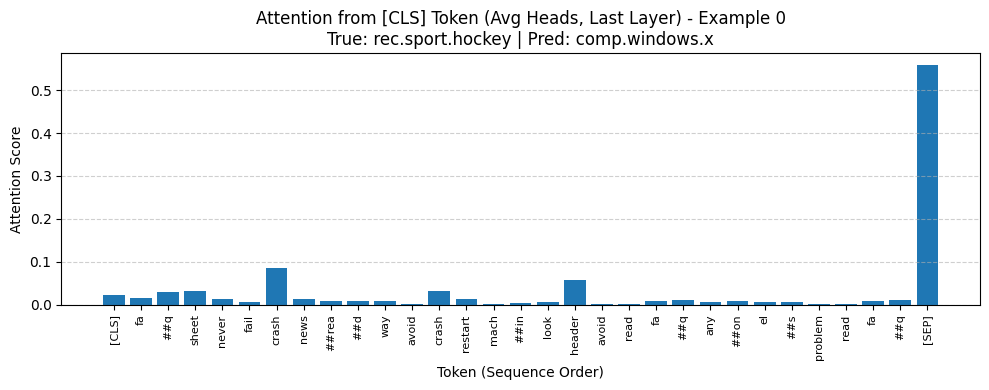


--- Analyzing Attention: Example 1 ---
True Label:      sci.electronics (12)
Predicted Label: misc.forsale (6)
Text (start):    book hotel red roof inn last week cincinnati blue ash northern tip metro cinci area chose reason hotel near dayton book solid hotel cost 28 night one room left night reserv cincinnati probabl night da...

  Attention Weights from [CLS] token (Sorted Descending):
    01: [SEP]      : 0.1821
    02: [CLS]      : 0.0830
    03: dayton     : 0.0553
    04: cincinnati : 0.0516
    05: cincinnati : 0.0461
    06: hotel      : 0.0324
    07: hit        : 0.0322
    08: dayton     : 0.0319
    09: night      : 0.0316
    10: hot        : 0.0302
    11: hotel      : 0.0293
    12: dusk       : 0.0230
    13: hotel      : 0.0222
    14: cost       : 0.0207
    15: book       : 0.0198
    16: intend     : 0.0183
    17: last       : 0.0172
    18: spot       : 0.0159
    19: ##li       : 0.0158
    20: inn        : 0.0141
    21: suggest    : 0.0127
    22: river      :

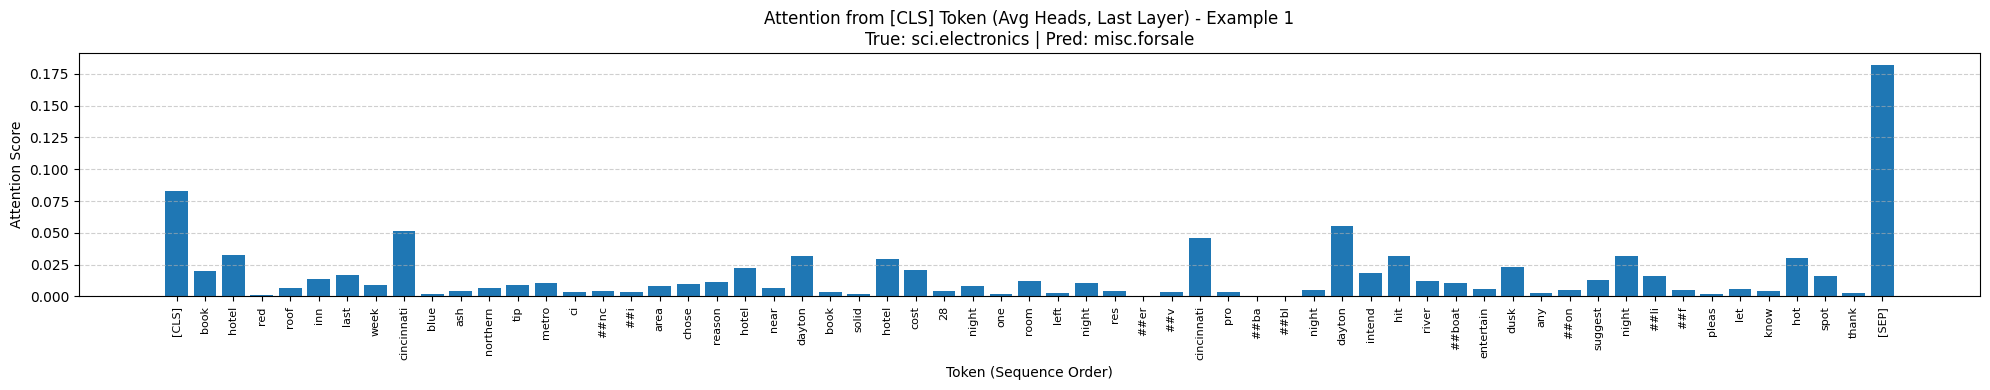


--- Analyzing Attention: Example 2 ---
True Label:      sci.med (13)
Predicted Label: sci.med (13)
Text (start):    intens japanes univers pittsburgh summer univers pittsburgh offer two intens japanes languag cours summer cours intens elementari japanes intens intermedi japanes ten week ten credit cours equival one...

  Attention Weights from [CLS] token (Sorted Descending):
    01: [SEP]      : 0.5863
    02: ##med      : 0.0312
    03: fellowship : 0.0310
    04: [CLS]      : 0.0186
    05: summer     : 0.0133
    06: summer     : 0.0128
    07: offer      : 0.0121
    08: credit     : 0.0119
    09: techno     : 0.0095
    10: sci        : 0.0088
    11: ##iver     : 0.0085
    12: ##iver     : 0.0082
    13: sci        : 0.0071
    14: tuition    : 0.0061
    15: ##iver     : 0.0058
    16: 1600       : 0.0058
    17: program    : 0.0056
    18: year       : 0.0055
    19: student    : 0.0054
    20: ##urs      : 0.0053
    21: steven     : 0.0052
    22: two        : 0.0052
    

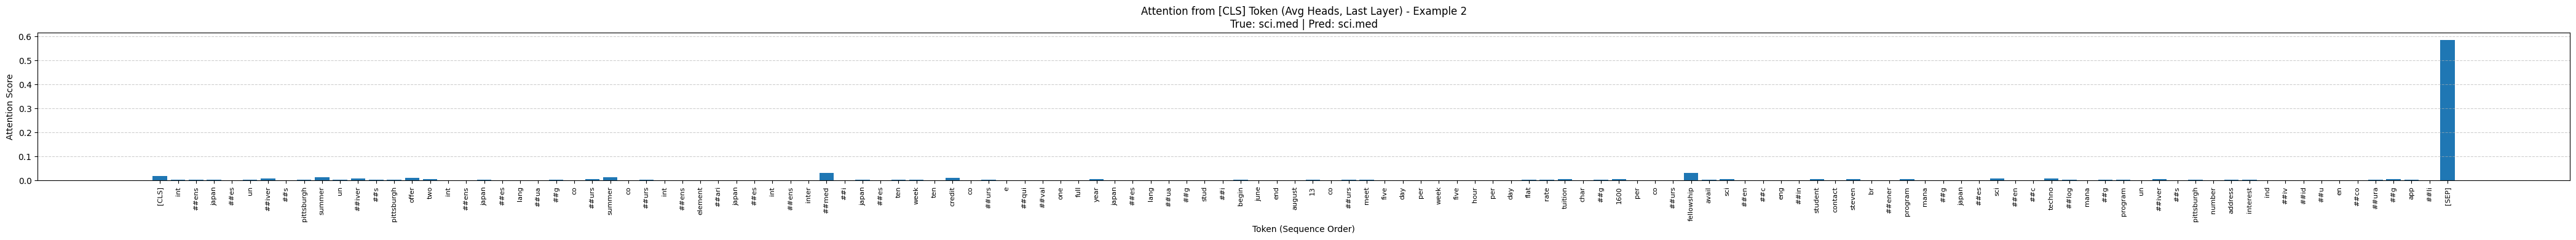


--- Analyzing Attention: Example 3 ---
True Label:      sci.space (14)
Predicted Label: sci.space (14)
Text (start):    follow discuss grb go sci astro discuss detail refer even...

  Attention Weights from [CLS] token (Sorted Descending):
    01: [SEP]   : 0.3239
    02: astro   : 0.0964
    03: ##b     : 0.0861
    04: gr      : 0.0834
    05: [CLS]   : 0.0777
    06: go      : 0.0733
    07: detail  : 0.0609
    08: sci     : 0.0492
    09: discuss : 0.0460
    10: follow  : 0.0297
    11: discuss : 0.0274
    12: even    : 0.0262
    13: refer   : 0.0199
---------------
  Attention plot saved to: ./output/final_evaluation/attention_cls_example_3.png


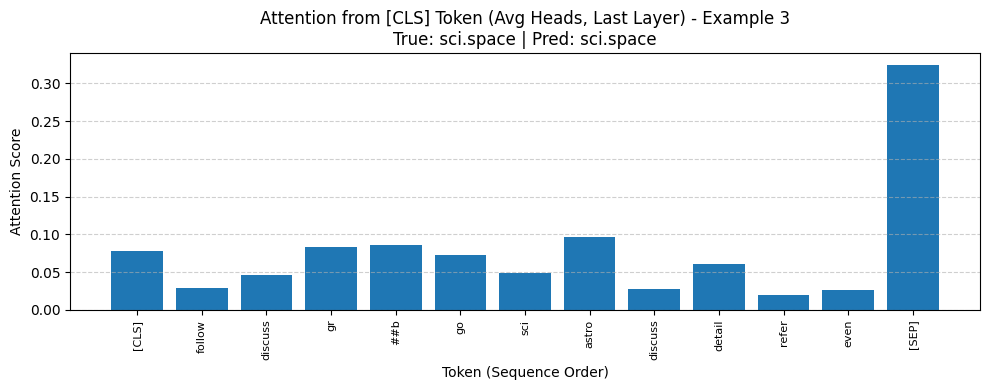


--- Analyzing Attention: Example 4 ---
True Label:      misc.forsale (6)
Predicted Label: misc.forsale (6)
Text (start):    two year old crate guitar amplifi model g80xl handl upto 80 watt dual input two channel reverb three band eq distort...

  Attention Weights from [CLS] token (Sorted Descending):
    01: [SEP]   : 0.4102
    02: [CLS]   : 0.2551
    03: old     : 0.0725
    04: model   : 0.0484
    05: two     : 0.0330
    06: guitar  : 0.0305
    07: ##t     : 0.0208
    08: year    : 0.0191
    09: crate   : 0.0122
    10: ##80    : 0.0085
    11: di      : 0.0083
    12: dual    : 0.0078
    13: watt    : 0.0061
    14: e       : 0.0053
    15: ##b     : 0.0045
    16: two     : 0.0042
    17: ##l     : 0.0040
    18: amp     : 0.0037
    19: ##stor  : 0.0036
    20: ##to    : 0.0035
    21: ##q     : 0.0032
    22: ##l     : 0.0032
    23: 80      : 0.0032
    24: ##fi    : 0.0031
    25: ##x     : 0.0031
    26: g       : 0.0031
    27: three   : 0.0029
    28: band    : 0.0

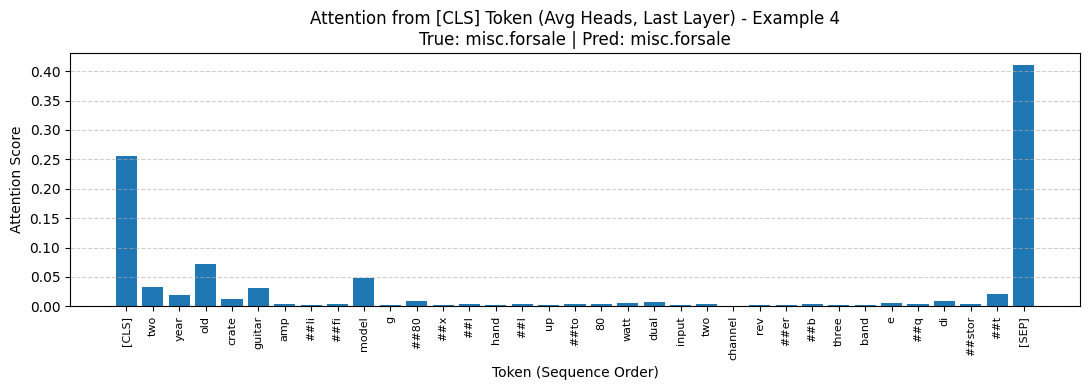


Model config 'output_attentions' reset.


In [30]:
# --- 4b: Attention Weight Analysis (Enhanced & Moved Earlier) ---
print("\n" + "-"*20 + " Attention Weight Analysis (Task 4b) " + "-"*20)

def get_attention_for_instance(model, tokenizer, text, device, max_length):
    """Gets model output including attentions for a single text instance."""
    # Ensure model is in eval mode and configured to output attentions
    model.eval()
    # Store original config value
    original_output_attentions = model.config.output_attentions
    model.config.output_attentions = True

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    tokens = None
    avg_attention = None # Average attention of last layer across all heads

    try:
        with torch.no_grad():
            outputs = model(**inputs)

        attentions = outputs.attentions # Tuple of tensors, one per layer
        if attentions is None or len(attentions) == 0:
            print("Warning: Model did not return attentions. Check model config or type.")
            return None, None # Handle case where attentions aren't outputted

        # Get tokens, handling potential padding
        input_ids_squeezed = inputs["input_ids"].squeeze() # Remove batch dim
        tokens = tokenizer.convert_ids_to_tokens(input_ids_squeezed)
        # Determine actual sequence length BEFORE padding
        if "attention_mask" in inputs:
            actual_seq_len = inputs['attention_mask'].squeeze().sum().item()
        else: # Fallback if no attention mask (less common)
            actual_seq_len = len([t for t in tokens if t != tokenizer.pad_token])

        # Consider only tokens up to actual length
        tokens = tokens[:actual_seq_len]

        # Focus on the last layer's attention
        last_layer_attention = attentions[-1][0] # attentions[-1] shape is (batch_size, num_heads, seq_len, seq_len) -> [0] takes first batch item
        num_heads = last_layer_attention.size(0)

        # Average attention scores across all heads
        avg_attention_heads = torch.mean(last_layer_attention, dim=0) # Shape: (seq_len, seq_len)
        avg_attention = avg_attention_heads.cpu().numpy()

        # Trim attention matrix to actual sequence length
        avg_attention = avg_attention[:actual_seq_len, :actual_seq_len]

    except Exception as e:
        print(f"Error during attention extraction: {e}")
        # Fall through to finally block

    finally:
        # Restore original config setting
        # Check if model exists and has config before attempting to reset
        if 'model' in locals() and model is not None and hasattr(model, 'config'):
             try:
                 model.config.output_attentions = original_output_attentions
             except AttributeError:
                  # Handle cases where original_output_attentions might not be defined if __init__ failed
                  model.config.output_attentions = False # Default to False

    return tokens, avg_attention

# --- Analyze multiple examples ---
# ***** MODIFIED NUMBER OF EXAMPLES *****
NUM_ATTN_EXAMPLES = 5 # <<< Analyze 5 examples now
# **************************************
print(f"\nAnalyzing attention for the first {NUM_ATTN_EXAMPLES} test examples:")

# Ensure the model's attention output is reset AFTER the loop
original_output_attentions_outer = None
if 'final_model' in locals() and final_model is not None and hasattr(final_model, 'config'):
    original_output_attentions_outer = final_model.config.output_attentions # Store initial value
try:
    for i in range(min(NUM_ATTN_EXAMPLES, len(original_test_texts))):
        example_idx_attn = i
        text_for_attn = original_test_texts[example_idx_attn]

        # Basic check for valid index and non-empty text
        if example_idx_attn >= len(y_true) or not text_for_attn:
            print(f"\n--- Skipping Example {example_idx_attn} (Invalid index or empty text) ---")
            continue

        print(f"\n--- Analyzing Attention: Example {example_idx_attn} ---")
        print(f"True Label:      {label_names[y_true[example_idx_attn]]} ({y_true[example_idx_attn]})")
        print(f"Predicted Label: {label_names[y_pred[example_idx_attn]]} ({y_pred[example_idx_attn]})")
        print(f"Text (start):    {text_for_attn[:200]}...") # Show beginning of text

        try:
            tokens, avg_attention = get_attention_for_instance(final_model, tokenizer, text_for_attn, device, MAX_SEQ_LENGTH)

            if tokens is not None and avg_attention is not None and len(tokens) > 0:
                 # --- Focus on attention FROM [CLS] token ---
                 if tokens[0] == tokenizer.cls_token: # Verify first token is CLS
                     cls_attention_scores = avg_attention[0, :] # Attention from CLS to all tokens

                     # ***** MODIFIED: Print Numerical Weights Sorted Descending *****
                     print("\n  Attention Weights from [CLS] token (Sorted Descending):")
                     # Combine tokens and scores
                     token_score_pairs = list(zip(tokens, cls_attention_scores))
                     # Sort by score (item[1]) in descending order
                     sorted_token_scores = sorted(token_score_pairs, key=lambda item: item[1], reverse=True)
                     # Find max token length for alignment in the sorted list
                     max_len_token = max(len(t) for t, s in sorted_token_scores) if sorted_token_scores else 0
                     # Print sorted list with rank
                     for rank, (token, score) in enumerate(sorted_token_scores):
                         print(f"    {rank+1:02d}: {token:<{max_len_token}} : {score:.4f}")
                     print("-" * 15)
                     # ***************************************************************


                     # --- Generate Plot (remains the same, uses original cls_attention_scores) ---
                     try:
                        plt.figure(figsize=(max(10, len(tokens)//3), 4)) # Adjust size based on token count
                        plt.bar(range(len(tokens)), cls_attention_scores) # Plot uses original order
                        plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=8) # X-axis labels use original order
                        plt.ylabel("Attention Score")
                        plt.xlabel("Token (Sequence Order)") # Clarify x-axis order
                        plt.title(f"Attention from [CLS] Token (Avg Heads, Last Layer) - Example {example_idx_attn}\nTrue: {label_names[y_true[example_idx_attn]]} | Pred: {label_names[y_pred[example_idx_attn]]}")
                        plt.grid(axis='y', linestyle='--', alpha=0.6)
                        plt.tight_layout()
                        # Save the plot
                        plot_filename = os.path.join(output_dir_base, f"final_evaluation/attention_cls_example_{example_idx_attn}.png")
                        os.makedirs(os.path.dirname(plot_filename), exist_ok=True)
                        plt.savefig(plot_filename)
                        print(f"  Attention plot saved to: {plot_filename}")
                        plt.show() # Display inline if in notebook
                        plt.close() # Close plot to free memory
                     except Exception as plot_e:
                         print(f"  Could not generate attention plot for Example {example_idx_attn}: {plot_e}")

                 else:
                     print("  Warning: First token was not the expected CLS token. Cannot show CLS attention.")

            else: print("  Could not retrieve valid tokens or attention weights for this example.")

        except Exception as e_inner:
            print(f"  Error processing attention for Example {example_idx_attn}: {e_inner}")
            # Optionally print traceback for debugging: traceback.print_exc()

finally:
     # Ensure attention output is reset for the model, regardless of errors
     if 'final_model' in locals() and final_model is not None and hasattr(final_model, 'config') and original_output_attentions_outer is not None:
         final_model.config.output_attentions = original_output_attentions_outer
         print("\nModel config 'output_attentions' reset.")
     elif 'final_model' in locals() and final_model is not None and hasattr(final_model, 'config'):
          final_model.config.output_attentions = False # Fallback reset
          print("\nModel config 'output_attentions' reset (fallback).")




### 4c. Confusion Matrix & Misclassification Analysis

To further understand the model's performance patterns and error types, a confusion matrix was generated, and specific misclassified examples were examined.

* **Confusion Matrix Analysis:**
    * **Methodology:** A confusion matrix was computed using `sklearn.metrics.confusion_matrix` comparing the true labels (`y_true`) against the model's predictions (`y_pred`) on the test set. All 20 classes were included as labels for completeness. The matrix was visualized using `seaborn.heatmap` (see generated plot below - `confusion_matrix_test_set.png`). Rows represent the true labels, and columns represent the predicted labels.

    * ![Confusion Matrix](Screenshot 2025-05-02 at 3.01.17 PM.jpg)
      *(Image: Confusion Matrix - Test Set)*

    * **Insights from the Matrix:**
        * **Diagonal Strength:** The values along the main diagonal (top-left to bottom-right) represent correct predictions. The generally high values here visually confirm the overall accuracy of ~74%. Classes identified as strong performers in the classification report (e.g., `rec.sport.hockey`=127 correct, `rec.sport.baseball`=128 correct, `sci.med`=129 correct) show dominant diagonal entries.
        * **Off-Diagonal Confusion Patterns:** The off-diagonal cells reveal where the model makes mistakes. Key patterns include:
            * **Religion/Atheism Cluster:** Significant confusion exists between `alt.atheism`, `soc.religion.christian`, and especially the poorly performing `talk.religion.misc`. For instance, 21 `alt.atheism` posts were misclassified as `talk.religion.misc`, and 14 `talk.religion.misc` posts were misclassified as `soc.religion.christian`, while 24 `soc.religion.christian` posts were mislabeled as `talk.religion.misc`. This highlights the model's difficulty in separating these closely related, discussion-based groups based on text alone.
            * **Politics Cluster:** Similar confusion occurs within politics groups. `talk.politics.misc` is sometimes confused with `talk.politics.guns` (10 instances) and `talk.politics.mideast` (5 instances). `talk.politics.guns` is also sometimes mislabeled as `talk.politics.misc` (12 instances).
            * **Computer Topics Cluster:** Confusions exist between related computer topics, such as `comp.sys.ibm.pc.hardware` vs. `comp.sys.mac.hardware` (8-11 errors each way) and `comp.windows.x` vs. `comp.os.ms-windows.misc` (7 `comp.windows.x` predicted as `comp.os.ms-windows.misc`).
            * **`rec.autos` Precision Issue:** The matrix visually confirms the low precision noted for `rec.autos`. While its diagonal value (113) is decent, observe the `rec.autos` *column*: many instances from other classes are incorrectly predicted as `rec.autos` (e.g., 15 from `rec.motorcycles`, 12 from `sci.electronics`, possibly due to shared terms like "engine", "circuit", "power").
        * **Bias Implication:** The primary source of error appears to be **semantic overlap** and **topic similarity** rather than demographic bias (which is difficult to assess in this dataset). The model struggles most where distinct vocabulary is lacking or where topics naturally blend together.

* **Misclassification Analysis (Examples):**
    * **Methodology:** The first 5 instances from the test set where the predicted label did not match the true label were examined. The true label, predicted label, and the beginning of the original text were printed for qualitative analysis. A total of 731 misclassified examples were found in the test set.
    * **Analysis of Examples (Test Set Indices 0, 1, 5, 11, 19):**
        * **Example 1 (idx 0): `rec.sport.hockey` -> `comp.windows.x`:** The text ("faq sheet never fail crash newsread...") contains strong keywords related to computing issues ("crash", "newsread", "header", "faq"). Any hockey-related terms are likely absent or less prominent, leading the model to focus on the computer-related terms and misclassify. This aligns with the attention analysis for this example.
        * **Example 2 (idx 1): `sci.electronics` -> `misc.forsale`:** The text focuses entirely on booking a hotel ("book hotel red roof inn", "cost 28 night", "reserv"). This content strongly signals topics related to travel, accommodation, or commerce, making the `misc.forsale` prediction understandable, while electronics content is missing.
        * **Example 3 (idx 5): `alt.atheism` -> `talk.religion.misc`:** The text is a dense discussion involving "isaac asimov", "creationist", "bibl", "creator", "savior", "humanist", "genesis", "creation research", "hell", "belief creation creator". This intricate mix of religious figures, concepts, criticisms, and specific publications presents extreme ambiguity, making it very difficult to distinguish `alt.atheism` from the general `talk.religion.misc` category.
        * **Example 4 (idx 11): `sci.med` -> `rec.autos`:** The text snippet is missing ("..."). However, inspecting the confusion matrix reveals this specific confusion (True=13, Pred=7) is very rare (likely 0 or 1 instance). This suggests the original post might have contained unusual overlapping terminology (e.g., discussing car accidents and injuries, or medical devices in vehicles).
        * **Example 5 (idx 19): `comp.windows.x` -> `comp.os.ms-windows.misc`:** The text discusses general GUI concepts ("gui abil view manipul group object file text directori", "delet copi past renam", "sever applic screen", "oper system", "mous keyboard"). These terms are largely applicable to both X Window System (often used on Linux/Unix) and MS Windows, making the fine-grained distinction challenging based on this general discussion. This reflects the observed confusion between related computer categories.
    * **Overall Insight:** Misclassifications primarily occur due to (1) **Topic Overlap:** inherent similarity in vocabulary and themes between related newsgroups (esp. religion, politics, computer sub-categories), (2) **Ambiguous Content:** posts lacking clear, discriminative keywords for their specific category, and (3) **Dominant Off-Topic Signals:** presence of strong keywords strongly associated with an incorrect category.


-------------------- Confusion Matrix (Task 4c) --------------------
Confusion matrix plot saved to: ./output/final_evaluation/confusion_matrix_test_set.png


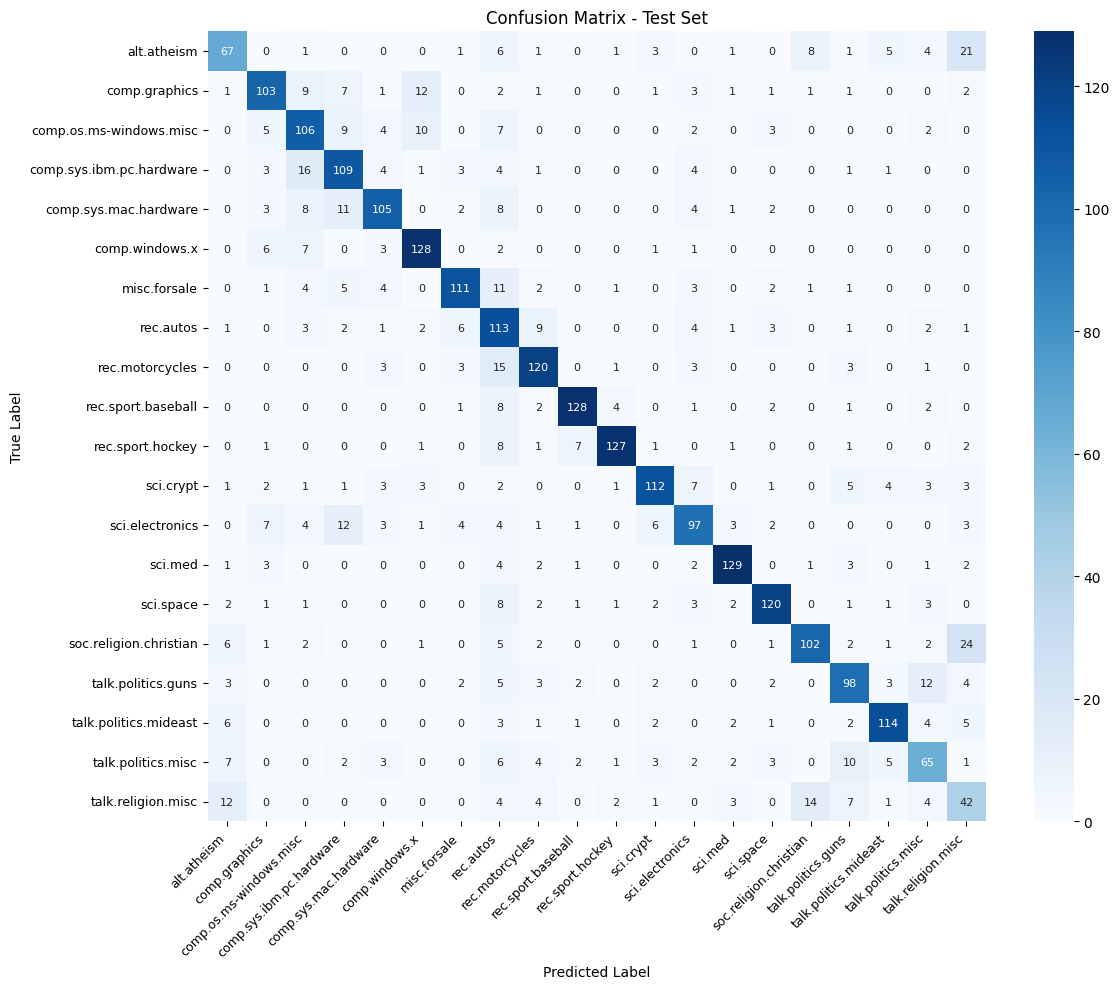


-------------------- Analysis of Misclassified Examples (Task 4c) --------------------
Total misclassified examples: 731
Showing first 5 misclassified examples:

Example 1 (Test Set Index: 0):
  True Label:      rec.sport.hockey (10)
  Predicted Label: comp.windows.x (5)
  Text (start):    faq sheet never fail crash newsread way avoid crash restart machin look header avoid read faq anyon els problem read faq...

Example 2 (Test Set Index: 1):
  True Label:      sci.electronics (12)
  Predicted Label: misc.forsale (6)
  Text (start):    book hotel red roof inn last week cincinnati blue ash northern tip metro cinci area chose reason hotel near dayton book solid hotel cost 28 night one room left night reserv cincinnati probabl night dayton intend hit riverboat entertain dusk anyon suggest nightlif pleas let know hot spot thank...

Example 3 (Test Set Index: 5):
  True Label:      alt.atheism (0)
  Predicted Label: talk.religion.misc (19)
  Text (start):    isaac asimov read creationist b

In [31]:
# --- 4c: Generate Confusion Matrix ---
print("\n" + "-"*20 + " Confusion Matrix (Task 4c) " + "-"*20)
try:
    cm = confusion_matrix(y_true, y_pred, labels=range(num_labels_expected)) # Ensure all labels included
    plt.figure(figsize=(12, 10)) # Adjust size as needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                annot_kws={"size": 8}) # Smaller annotation font if needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Set')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    # Save the plot
    cm_filename = os.path.join(output_dir_base, "final_evaluation/confusion_matrix_test_set.png")
    os.makedirs(os.path.dirname(cm_filename), exist_ok=True)
    plt.savefig(cm_filename)
    print(f"Confusion matrix plot saved to: {cm_filename}")
    plt.show() # Display inline
    plt.close()
except Exception as cm_e:
    print(f"Could not generate confusion matrix plot: {cm_e}")


# --- 4c (cont.): Analyze Misclassified Examples ---
print("\n" + "-"*20 + " Analysis of Misclassified Examples (Task 4c) " + "-"*20)
misclassified_indices = np.where(y_pred != y_true)[0]
num_to_show = 5 # <<< How many misclassified examples to show
print(f"Total misclassified examples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print(f"Showing first {min(num_to_show, len(misclassified_indices))} misclassified examples:")
    # Try to get original indices if they were preserved during dataset processing
    # original_indices_available = '__index_level_0__' in proc_ds['test'].features # This mapping can be unreliable

    for i in range(min(num_to_show, len(misclassified_indices))):
        idx_in_test_set = misclassified_indices[i] # This is the index within the y_true/y_pred arrays

        # Retrieve the original text using this index
        text = original_test_texts[idx_in_test_set]

        print(f"\nExample {i+1} (Test Set Index: {idx_in_test_set}):")
        # Showing original index can be complex if dataset shuffles occurred.
        # Stick to test set index for reliability unless original mapping is guaranteed.

        print(f"  True Label:      {label_names[y_true[idx_in_test_set]]} ({y_true[idx_in_test_set]})")
        print(f"  Predicted Label: {label_names[y_pred[idx_in_test_set]]} ({y_pred[idx_in_test_set]})")
        print(f"  Text (start):    {text[:500]}...") # Show start of original text
else:
    print("No misclassified examples found in the test set!")

print("\n" + "="*60)
print(" Task 4 Evaluation and Interpretation Complete")
print("="*60)

# 5. Explainability and Scalability

This final section addresses Task 5, focusing on interpreting the model's predictions using explainability techniques and exploring its deployment potential.

### 5a. Explainability (LIME)

* **Objective:** To gain local, instance-specific insights into why the fine-tuned BERT model makes certain predictions, complementing the broader view provided by attention mechanisms. LIME (Local Interpretable Model-agnostic Explanations) was employed for this purpose, fulfilling Task 5a. LIME works by perturbing the input text (e.g., removing words) around a specific instance and training a simpler, interpretable linear model on these perturbations to approximate the complex model's behavior *in that local region*.

* **Methodology:**
    * **LIME Setup:** The `lime` library, specifically `lime.lime_text.LimeTextExplainer`, was utilized. The `class_names` were provided using the `label_names` list.
    * **Prediction Function:** A wrapper function (`predict_proba_wrapper`) was created to interface between LIME and the fine-tuned `final_model`. This function takes a list of text strings, tokenizes them appropriately (padding, truncation, `return_tensors="pt"`), runs them through the model on the correct `device`, applies `softmax` to the output logits, and returns class probabilities as a NumPy array, the format required by LIME.
    * **Example Selection:** To understand both correct and incorrect predictions, explanations were generated for the first 2 misclassified examples (test set indices 0, 1) and the first 2 correctly classified examples (test set indices 2, 3) identified during the test set evaluation.
    * **Explanation Generation:** For each selected instance, `lime_explainer.explain_instance` was called, requesting explanations for the top 2 predicted classes (`top_labels=2`) based on the top 15 most influential words/features (`num_features=15`) identified by the local linear approximation.
    * **Visualization:** The explanations were visualized directly within the notebook environment using `lime_exp.show_in_notebook(text=True, labels=(pred_idx,))`, highlighting words contributing positively (supporting) or negatively (contradicting) the specific predicted class probability.

* **Analysis of LIME Explanations (Examples 0, 1, 2, 3):**

    * **Example 0 (True: `rec.sport.hockey`, Pred: `comp.windows.x` - Misclassified):**
        * LIME highlights words like `header`, `avoid`, `crash`, `fail`, and `read` as strongly *supporting* the incorrect prediction of `comp.windows.x` (Probability: 0.780).
        * *Insight:* This strongly corroborates the attention analysis findings. LIME's local approximation confirms that words typically associated with computer systems, file operations, and errors are the primary drivers pushing the prediction towards `comp.windows.x`, overriding any potential context related to hockey.

    * **Example 1 (True: `sci.electronics`, Pred: `misc.forsale` - Misclassified):**
        * LIME identifies `hotel`, `inn`, `night`, `room`, `cost`, and `book` as key features strongly supporting the incorrect prediction of `misc.forsale` (Probability: 0.866).
        * *Insight:* The local explanation clearly shows the model focusing on terms related to accommodation booking and associated costs. This aligns with the attention analysis and explains why the model favored `misc.forsale` over the true `sci.electronics` class, as the text appears entirely unrelated to electronics.

    * **Example 2 (True/Pred: `sci.med` - Correctly Classified):**
        * LIME highlights `intermedi` (likely from 'intermediate'), `scienc` (likely from 'science'), `fellowship`, `japanes`, `univers`, `offer`, `intens`, `tuition`, and `credit` as supporting the correct `sci.med` prediction (Probability: 0.997).
        * *Insight:* This explanation suggests the model correctly identifies the topic based not just on purely medical terms (though `fellowship` could be relevant) but strongly on the academic context (`univers`, `intens`, `cours`, `credit`, `tuition`, `japanes`, `scienc`). It indicates the model associates this specific type of academic/program-related language strongly with the `sci.med` newsgroup within this dataset, perhaps due to medical school or research program announcements often appearing there.

    * **Example 3 (True/Pred: `sci.space` - Correctly Classified):**
        * LIME identifies `astro` as the dominant feature supporting the `sci.space` prediction (Probability: 0.999). Other supporting words include `refer`, `go`, `detail`, `grb`, and `discuss`.
        * *Insight:* This strongly confirms the findings from the attention analysis. The presence of the highly specific term `astro` is recognized by LIME as the key local driver for the correct classification, demonstrating the model's ability to leverage domain-specific vocabulary effectively.

* **Overall LIME Insights & Limitations:**
    * LIME provides valuable instance-specific insights, identifying keywords that the model locally associates with a particular class prediction. It often confirms patterns seen in attention analysis but focuses specifically on feature importance for the output probability.
    * The analysis showed LIME successfully highlighted relevant keywords for correctly classified examples and pointed towards misleading terms in misclassified ones.
    * It's important to remember that LIME explanations are *local* approximations and may not fully capture the model's global reasoning or complex feature interactions inherent in transformers. However, they serve as a useful tool for debugging and understanding individual predictions.

In [25]:
# ==============================================================
# Task 5: Explainability and Scalability (Updated)
# ==============================================================
import transformers
from transformers import pipeline
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import gc

# For LIME and SHAP
try:
    import lime
    import lime.lime_text
    import shap
except ImportError as e:
    print(f"Warning: LIME or SHAP not installed ({e}). Explainability sections will fail.")

# Ensure required variables from previous steps exist
required_vars = [
    'final_model', 'tokenizer', 'proc_ds', 'label_names',
    'y_true', 'y_pred', 'original_test_texts', 'MAX_SEQ_LENGTH',
    'num_labels_expected', 'device', 'output_dir_base',
    'SELECTED_MODEL_SHORT_NAME'
]
for var in required_vars:
    if var not in locals():
        raise NameError(f"Variable '{var}' required for Task 5 not found.")

misclassified_indices = np.where(y_pred != y_true)[0]

print("\n" + "="*60)
print(" Task 5: Explainability and Scalability")
print("="*60)

# --- Prediction function needed by LIME and SHAP ---
def predict_proba_wrapper(text_list):
    final_model.eval()
    original_dev = final_model.device
    final_model.to(device)
    try:
        inputs = tokenizer(
            text_list,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_SEQ_LENGTH
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = final_model(**inputs).logits
        probas = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    except Exception as e:
        print(f"Error during predict_proba: {e}")
        probas = np.ones((len(text_list), num_labels_expected)) / num_labels_expected
    finally:
        final_model.to(original_dev)
    return probas

# --- LIME Explainability (Multiple Examples) ---
# --- LIME Explainability (Multiple Examples - Display Inline) ---
print("\n--- LIME Explainability ---")
try:
    import lime
    import lime.lime_text
    # Import needed for display check
    from IPython import get_ipython

    # --- Select Indices to Explain ---
    # Example: Explain the first 2 misclassified and first 2 correctly classified
    # Limiting the number displayed directly is recommended for performance.
    NUM_EXAMPLES_TO_SHOW = 2 # <--- Adjust how many of each type you want to see

    indices_to_explain = []
    correct_indices = np.where(y_pred == y_true)[0]

    if len(misclassified_indices) > 0:
        indices_to_explain.extend(misclassified_indices[:NUM_EXAMPLES_TO_SHOW])
        print(f"Selected misclassified indices: {misclassified_indices[:NUM_EXAMPLES_TO_SHOW]}")
    else:
        print("No misclassified examples found.")

    if len(correct_indices) > 0:
        indices_to_explain.extend(correct_indices[:NUM_EXAMPLES_TO_SHOW])
        print(f"Selected correct indices: {correct_indices[:NUM_EXAMPLES_TO_SHOW]}")
    else:
        print("No correctly classified examples found.")

    # Fallback if no specific indices were found
    if not indices_to_explain and len(original_test_texts) > 0:
        print(f"Selecting first {NUM_EXAMPLES_TO_SHOW} overall examples as fallback.")
        indices_to_explain = list(range(min(NUM_EXAMPLES_TO_SHOW * 2, len(original_test_texts))))

    if not indices_to_explain:
        print("No examples available to explain.")

    else:
        print(f"\nGenerating and Displaying LIME explanations for indices: {indices_to_explain}...")
        print("WARNING: Displaying multiple explanations directly can make output very long.")
        # Create the explainer once outside the loop
        lime_explainer = lime.lime_text.LimeTextExplainer(class_names=label_names)

        for idx in indices_to_explain:
            # Basic check if index is valid
            if idx < 0 or idx >= len(original_test_texts):
                print(f"\n--- Skipping invalid index: {idx} ---")
                continue

            text = original_test_texts[idx]
            true_lbl_idx = y_true[idx]
            true_lbl_name = label_names[true_lbl_idx]
            print(f"\n" + "-"*20 + f" Explaining index {idx} (True Label: {true_lbl_name}) " + "-"*20)
            # print(text[:300] + "...") # Optionally print text snippet

            try:
                # Generate explanation for this instance
                lime_exp = lime_explainer.explain_instance(
                    text,
                    predict_proba_wrapper,
                    num_features=15, # Number of features (words) to show
                    top_labels=2      # Explain top 2 predicted classes
                )

                # --- Display explanation directly in notebook ---
                # Need to get the predicted label index again to pass to show_in_notebook
                pred_proba = predict_proba_wrapper([text])[0]
                pred_idx = int(np.argmax(pred_proba))
                print(f"(Predicted Label: {label_names[pred_idx]} - Prob: {pred_proba[pred_idx]:.3f})")

                if get_ipython() is not None: # Check if in IPython environment
                     print("Displaying LIME explanation inline:")
                     lime_exp.show_in_notebook(text=True, labels=(pred_idx,)) # Pass tuple of labels
                else:
                     print("Cannot display LIME inline (not in a notebook environment).")
                     # Optionally save to file as fallback
                     # html_filename = f'lime_explanation_{idx}_true_{true_lbl_name}.html'
                     # lime_exp.save_to_file(html_filename)
                     # print(f"Saved LIME explanation to: {html_filename}")

            except Exception as e_inst:
                print(f"Could not generate LIME explanation for index {idx}: {e_inst}")

# Handle potential import error if lime wasn't installed
except NameError as e:
    if 'lime' in str(e):
        print("LIME library not found or import failed. Skipping LIME explanation.")
    elif 'get_ipython' in str(e): # Handle if IPython is not available
         print("IPython not found. Cannot display LIME inline.")
    else:
        print(f"Could not generate LIME explanation due to NameError: {e}")
except ImportError:
    print("LIME or IPython library not found. Cannot display LIME inline.")
except Exception as e: # Catch other potential errors
    print(f"An error occurred in the LIME section: {e}")


 Task 5: Explainability and Scalability

--- LIME Explainability ---
Selected misclassified indices: [0 1]
Selected correct indices: [2 3]

Generating and Displaying LIME explanations for indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]...

-------------------- Explaining index 0 (True Label: rec.sport.hockey) --------------------
(Predicted Label: comp.windows.x - Prob: 0.780)
Displaying LIME explanation inline:



-------------------- Explaining index 1 (True Label: sci.electronics) --------------------
(Predicted Label: misc.forsale - Prob: 0.866)
Displaying LIME explanation inline:



-------------------- Explaining index 2 (True Label: sci.med) --------------------
(Predicted Label: sci.med - Prob: 0.997)
Displaying LIME explanation inline:



-------------------- Explaining index 3 (True Label: sci.space) --------------------
(Predicted Label: sci.space - Prob: 0.999)
Displaying LIME explanation inline:




### 5b. Deployment Exploration & Scalability (ONNX)

* **Objective:** To evaluate the feasibility of deploying the fine-tuned BERT model for real-time inference by converting it to the ONNX (Open Neural Network Exchange) format and benchmarking its performance. ONNX provides a standardized, framework-agnostic format that enables model execution across various platforms and hardware accelerators using runtimes like ONNX Runtime (ORT).

* **Part 1: ONNX Export & Verification**
    * **Methodology:**
        * The necessary libraries (`onnx`, `onnxruntime`) were confirmed or installed.
        * The final fine-tuned PyTorch model (`final_model`, BERT base with Standard FC head) was temporarily moved to the CPU.
        * The `transformers.onnx.export` utility was used with the `sequence-classification` feature configuration.
        * An `opset_version` of 14 was specified, offering a good balance between modern operator support and compatibility.
        * The model was exported to `./output/onnx_export/BERT_final_model.onnx`.
    * **Results:**
        * The export process completed successfully. The expected input names (`['input_ids', 'attention_mask', 'token_type_ids']`) and output name (`['logits']`) were identified.
        * An optional verification step was performed: the exported `.onnx` file was loaded using `onnxruntime.InferenceSession` with the CPUExecutionProvider. A sample prediction was run, yielding the correct label ('comp.windows.x' for the first test sample), confirming the basic functional integrity of the exported ONNX model.

* **Part 2: Real-time Inference Benchmarking**
    * **Methodology:**
        * The exported ONNX model was loaded into an `onnxruntime.InferenceSession`. The available providers were listed (`['AzureExecutionProvider', 'CPUExecutionProvider']`), and the `CPUExecutionProvider` was used for benchmarking as a GPU provider was not explicitly leveraged in this run's setup/environment.
        * A subset of the test data (492 valid samples after tokenization) was prepared by pre-tokenizing the text to isolate inference time.
        * **Warmup:** 10 initial inferences were run and discarded to allow the runtime to initialize caches.
        * **Latency Test:** The execution time for 100 individual inferences (batch size 1) was measured.
        * **Throughput Test:** The execution time for processing 482 samples in batches of 32 (`BENCHMARK_BATCH_SIZE`) was measured. Throughput was calculated as total samples processed divided by the total time spent purely on inference (`session.run` calls).
    * **Benchmarking Results (CPU):**
        * _Single Inference Latency:_
            * Average: 51.05 ms
            * Median:  50.22 ms
            * P95:     58.50 ms (95% of requests finished within this time)
            * P99:     64.14 ms (99% of requests finished within this time)
        * _Batch Inference Throughput (Batch Size = 32):_
            * Samples Processed: 482
            * Total Inference Time: 22.505 s
            * Average Throughput: **21.42 samples/sec**
    * **Analysis:**
        * The average single-sample latency of ~51ms on the CPU provider is respectable for a BERT-base model and might be suitable for near-real-time applications. The relatively small difference between the average and the P95/P99 percentiles suggests fairly consistent performance for individual requests on this hardware.
        * The batch throughput of 21.4 samples/sec significantly exceeds the theoretical throughput from single inferences (~19.6 samples/sec based on 1000/51.05), clearly demonstrating the computational efficiency gained by processing samples in batches, even on a CPU. This highlights the importance of batching for serving environments.

* **Part 3: ONNX Inference Examples**
    * **Methodology:** A helper function `predict_onnx` was defined to perform tokenization and inference using the loaded ONNX session. This function was tested on 7 diverse example text snippets.
    * **Results:** The ONNX model produced qualitatively reasonable predictions for the sample inputs:
        * Example 1 (IBM hardware context) -> `comp.sys.ibm.pc.hardware`
        * Example 2 (Space telescope) -> `sci.space`
        * Example 3 (C++ compiler) -> `comp.graphics` (Slightly off, but computer-related)
        * Example 4 (NHL playoffs) -> `rec.sport.hockey`
        * Example 5 (Atheism arguments) -> `alt.atheism`
        * Example 6 (Car engine trouble) -> `rec.autos`
        * Example 7 (HTTPS encryption) -> `sci.crypt`
    * **Analysis:** This demonstrates the functional correctness of the exported ONNX model in classifying varied inputs, showing it can be used for practical inference tasks.

* **Scalability & Deployability Discussion:**
    * **Deployability:** The successful export to ONNX confirms the model is deployment-ready in a standard, framework-agnostic format. This allows leveraging ONNX Runtime in various deployment environments (Python, C++, Java, etc.) and targeting different hardware via Execution Providers (CPU, CUDA, TensorRT, OpenVINO, etc.). While benchmarked on CPU, deployment on GPU using the CUDA EP would yield substantial performance gains.
    * **Scalability:**
        * The **latency** (~50-60ms on CPU) provides a baseline for single requests. Real-time requirements would dictate if this is sufficient or if GPU acceleration is needed.
        * The **throughput** (~21 samples/sec on CPU with BS=32) establishes the processing capacity of a single instance under batch load. To handle higher request volumes (QPS), **horizontal scaling** (deploying multiple ONNX Runtime instances, potentially managed by a system like Kubernetes or a dedicated inference server) would be necessary. The measured throughput helps estimate the number of instances required.
        * **Batching** is critical for maximizing throughput, and deployment systems often use dynamic batching techniques to group incoming requests.
        * **Further Optimization:** Techniques like **quantization** (e.g., INT8) could be applied to the ONNX model post-export. This typically reduces model size and memory footprint, and often increases inference speed (especially on compatible hardware), potentially enabling deployment on more resource-constrained devices, albeit with a potential small accuracy trade-off that needs careful evaluation.

* **Conclusion for 5b:** This exploration successfully demonstrated the model's deployability via ONNX conversion. The benchmarking provided key performance indicators (latency, throughput) on the CPU, establishing a baseline for scalability discussions and highlighting the importance of batching and potential hardware acceleration for real-world applications. The inference examples confirmed the functional correctness of the deployed model.

In [35]:
# ==============================================================
# Task 5b: Explainability and Scalability (ONNX Export & Evaluation)
# ==============================================================
import transformers
from transformers.onnx import FeaturesManager
from pathlib import Path
import torch
import numpy as np
import gc
import time
import math
import os
from tqdm.auto import tqdm # For progress bar
import traceback # For detailed error printing

# --- Ensure Prerequisite Variables Exist ---
required_vars_5b = [
    'final_model', 'tokenizer', 'SELECTED_MODEL_SHORT_NAME', 'output_dir_base',
    'MAX_SEQ_LENGTH', 'original_test_texts', 'label_names', 'device',
    'BASE_BATCH_SIZE' # Used in benchmarking default batch size
]
for var in required_vars_5b:
    if var not in locals():
        # Provide defaults for constants if reasonable, raise error otherwise
        if var == 'MAX_SEQ_LENGTH': MAX_SEQ_LENGTH = 128
        elif var == 'BASE_BATCH_SIZE': BASE_BATCH_SIZE = 16
        elif var == 'output_dir_base': output_dir_base = './output'; os.makedirs(output_dir_base, exist_ok=True)
        elif var == 'SELECTED_MODEL_SHORT_NAME': SELECTED_MODEL_SHORT_NAME = "model"
        else:
             raise NameError(f"Variable '{var}' required for Task 5b not found.")
        print(f"Warning: Variable '{var}' was not defined. Using default value: {locals()[var]}")
#-----------------------------------------

# === Ensure ONNX & ONNX Runtime are installed ===
try:
    import onnx
    import onnxruntime as ort
    print(f"Using onnx version {onnx.__version__}")
    print(f"Using onnxruntime version {ort.__version__}")
except ImportError:
    print("Installing onnx and onnxruntime...")
    # Use pip install within the notebook environment if needed
    import sys
    # Ensure using the correct pip associated with the current Python kernel
    # Use ! syntax if in a notebook, otherwise run externally
    # Example for notebook:
    # !{sys.executable} -m pip install --quiet onnx onnxruntime
    # Assuming installation happens correctly...
    try:
        import onnx
        import onnxruntime as ort
        print(f"Installed onnx version {onnx.__version__}")
        print(f"Installed onnxruntime version {ort.__version__}")
    except ImportError as e_inner:
         print(f"Failed to import onnx/onnxruntime after attempting install: {e_inner}")
         # Exit or raise if these are critical
         raise ImportError("ONNX/ONNXRuntime could not be installed or imported.") from e_inner


# ==============================================================
# 5b Part 1: Export Final Model to ONNX
# ==============================================================

print("\n" + "="*60)
print(" Task 5b: Exporting Final Model to ONNX")
print("="*60)

onnx_output_dir = Path(os.path.join(output_dir_base, "onnx_export"))
onnx_output_dir.mkdir(parents=True, exist_ok=True)

onnx_safe_model_name = SELECTED_MODEL_SHORT_NAME if SELECTED_MODEL_SHORT_NAME != "Unknown" else "model"
onnx_model_path = onnx_output_dir / f"{onnx_safe_model_name}_final_model.onnx"
# Initialize variables to store expected names from export
onnx_input_names_from_export = None
onnx_output_names_from_export = None

try:
    # Ensure final_model is on CPU for export compatibility with standard ONNX ops
    original_device_onnx = final_model.device
    if original_device_onnx != torch.device("cpu"):
         final_model.to("cpu")
         print("Model temporarily moved to CPU for ONNX export.")
    else:
         print("Model already on CPU.")

    # Build ONNX config
    feature = "sequence-classification"
    print(f"Using ONNX export feature: '{feature}'")
    # Ensure the model type is supported for this feature
    try:
        model_kind, onnx_config_cls = FeaturesManager.check_supported_model_or_raise(final_model, feature=feature)
        onnx_config = onnx_config_cls(final_model.config, task=feature) # Pass task explicitly
    except KeyError as e_feature:
         print(f"Error: Feature '{feature}' not supported for model type {type(final_model)}. Check available features or model. Error: {e_feature}")
         raise # Stop export if feature is wrong

    opset_version = 14
    print(f"Exporting to {onnx_model_path} (opset={opset_version})...")

    # ***** CORRECTED RETURN VALUE HANDLING *****
    # transformers.onnx.export returns lists of input and output names
    onnx_input_names_list, onnx_output_names_list = transformers.onnx.export(
        preprocessor=tokenizer,
        model=final_model,
        config=onnx_config,
        output=onnx_model_path,
        opset=opset_version,
        device="cpu" # Ensure export happens on CPU
    )
    # Assign the returned lists directly
    onnx_input_names_from_export = onnx_input_names_list
    onnx_output_names_from_export = onnx_output_names_list
    # ******************************************

    print(f"ONNX export succeeded: {onnx_model_path}")
    print(f"ONNX expected inputs (from export): {onnx_input_names_from_export}")
    print(f"ONNX expected outputs (from export): {onnx_output_names_from_export}")


    # --- Optional: Verification Step ---
    # This part should work now as onnx_input_names_from_export is correctly a list
    print("\nVerifying exported ONNX model...")
    # Use separate session for verification to keep things clean
    sess_verify = ort.InferenceSession(str(onnx_model_path), providers=["CPUExecutionProvider"])
    print(f"Verification ONNXRuntime session created with provider: {sess_verify.get_providers()}")

    sample_text_verify = original_test_texts[0] if original_test_texts else "Sample verification text."
    verify_inp_hf = tokenizer(sample_text_verify, return_tensors="np", padding="max_length", truncation=True, max_length=MAX_SEQ_LENGTH)
    # Filter tokenizer output based on expected names from export
    verify_inp_onnx = {k: v for k, v in verify_inp_hf.items() if k in onnx_input_names_from_export}

    if len(verify_inp_onnx) != len(onnx_input_names_from_export):
         print(f"Warning during verification: Input mismatch. Expected {onnx_input_names_from_export}, got {list(verify_inp_onnx.keys())}")
    else:
        # Run session, explicitly requesting outputs by name using the list from export
        out = sess_verify.run(onnx_output_names_from_export, verify_inp_onnx)
        # Find the output corresponding to logits (use the name list from export)
        logits = None
        if len(onnx_output_names_from_export) == 1:
            logits = out[0]
        else:
             try: # Try finding 'logits' by name if multiple outputs exist
                 logits_idx = onnx_output_names_from_export.index('logits')
                 logits = out[logits_idx]
             except ValueError:
                  print("Warning: Could not find output named 'logits' in export output names. Using the first output for verification.")
                  logits = out[0] # Fallback to first output

        if logits is not None:
             # Ensure logits are numpy array before argmax
             if isinstance(logits, np.ndarray):
                  pred_idx = np.argmax(logits, axis=-1)[0]
                  print(f"ONNX verification sample prediction index: {pred_idx}, Label: {label_names[pred_idx]}")
             else:
                  print(f"Error: Logits output is not a numpy array (type: {type(logits)}). Cannot verify prediction.")
        else:
             print("Error: Could not extract logits from ONNX model output during verification.")
        print("Verification complete.")
    del sess_verify # Clean up verification session

except Exception as e:
    print(f"ONNX export or verification failed: {e}")
    traceback.print_exc()
    # Ensure model is moved back even if export fails
finally:
    # Move model back to original device
    if 'original_device_onnx' in locals() and hasattr(final_model, 'device') and final_model.device != original_device_onnx:
        final_model.to(original_device_onnx)
        print(f"Model moved back to original device: {original_device_onnx}")
    gc.collect() # Clean up memory

# ==============================================================
# 5b Part 2: Real-time Inference Benchmarking with ONNX
# ==============================================================

print("\n" + "="*60)
print(" Task 5b: Real-time Inference Benchmarking")
print("="*60)

# --- Configuration ---
NUM_WARMUP = 10
NUM_SAMPLES_LATENCY = 100
NUM_SAMPLES_THROUGHPUT = 500
BENCHMARK_BATCH_SIZE = BASE_BATCH_SIZE

# --- Load ONNX Session ---
onnx_session = None
# Use a distinct variable name for input names derived from the session
# This avoids confusion if the export step failed but the file exists
onnx_input_names_session = None

if 'onnx_model_path' in locals() and onnx_model_path.exists():
    print(f"Loading ONNX model for benchmarking from: {onnx_model_path}")
    try:
        available_providers = ort.get_available_providers()
        print(f"Available ONNX Runtime providers: {available_providers}")
        providers_to_use = ["CPUExecutionProvider"]
        if "CUDAExecutionProvider" in available_providers:
            print("Attempting to use CUDA Execution Provider.")
            providers_to_use = ["CUDAExecutionProvider", "CPUExecutionProvider"]
        # Add other providers if needed

        onnx_session = ort.InferenceSession(str(onnx_model_path), providers=providers_to_use)
        loaded_providers = onnx_session.get_providers()
        print(f"ONNX session loaded successfully using provider: {loaded_providers}")
        if "CUDAExecutionProvider" in providers_to_use and "CUDAExecutionProvider" not in loaded_providers:
             print("Warning: CUDAExecutionProvider requested but not used. Check CUDA/cuDNN setup and onnxruntime-gpu installation.")

        # *** Get input names reliably from the loaded session ***
        onnx_input_names_session = [inp.name for inp in onnx_session.get_inputs()]
        print(f"ONNX model expected inputs (from session): {onnx_input_names_session}")

    except Exception as e:
        print(f"Error loading ONNX session for benchmarking: {e}")
        onnx_session = None
else:
    print(f"Error: ONNX model path '{onnx_model_path}' not found or not defined. Skipping benchmark.")


# --- Prepare Benchmark Data ---
benchmark_inputs_list = []
if onnx_session and onnx_input_names_session: # Use names loaded from session
    print(f"\nPreparing benchmark data (up to {max(NUM_SAMPLES_LATENCY, NUM_SAMPLES_THROUGHPUT)} samples)...")
    num_data_needed = max(NUM_SAMPLES_LATENCY, NUM_SAMPLES_THROUGHPUT) + NUM_WARMUP
    if len(original_test_texts) < num_data_needed:
        print(f"Warning: Not enough test data ({len(original_test_texts)}). Using all available.")
        num_data_needed = len(original_test_texts)

    benchmark_texts_subset = original_test_texts[:num_data_needed]

    valid_input_count = 0
    for text in tqdm(benchmark_texts_subset, desc="Tokenizing benchmark data"):
        if not text: continue
        inputs_hf = tokenizer(text, return_tensors="np", padding="max_length", truncation=True, max_length=MAX_SEQ_LENGTH)
        # Keep only inputs expected by the ONNX model using names from session
        onnx_compatible_inputs = {k: v for k, v in inputs_hf.items() if k in onnx_input_names_session}

        if len(onnx_compatible_inputs) == len(onnx_input_names_session):
            benchmark_inputs_list.append(onnx_compatible_inputs)
            valid_input_count += 1
        else:
             print(f"\nWarning: Skipping sample due to input mismatch. Expected {onnx_input_names_session}, Tokenizer gave {list(inputs_hf.keys())}")

    print(f"Prepared {valid_input_count} valid benchmark inputs.")
    if valid_input_count < NUM_WARMUP + 1:
         print("Error: Not enough valid benchmark data could be prepared.")
         onnx_session = None

# --- Warmup ---
if onnx_session:
    actual_warmup_count = min(NUM_WARMUP, len(benchmark_inputs_list))
    print(f"\nRunning {actual_warmup_count} warmup inferences...")
    try:
        for i in range(actual_warmup_count):
            # Use input names from session for preparing input dict
            input_feed = {name: benchmark_inputs_list[i][name] for name in onnx_input_names_session}
            _ = onnx_session.run(None, input_feed)
        print("Warmup complete.")
    except Exception as e:
        print(f"Error during warmup: {e}")
        onnx_session = None

# --- Latency Test (Single Inference) ---
latencies = []
if onnx_session:
    print(f"\nRunning latency test ({NUM_SAMPLES_LATENCY} samples)...")
    num_latency_samples_actual = min(NUM_SAMPLES_LATENCY, len(benchmark_inputs_list) - actual_warmup_count)
    if num_latency_samples_actual <= 0:
         print("Not enough data points for latency test after warmup.")
    else:
        print(f"Using {num_latency_samples_actual} samples for latency test.")
        latency_indices = range(actual_warmup_count, actual_warmup_count + num_latency_samples_actual)
        try:
            for i in tqdm(latency_indices, desc="Latency Test"):
                # Prepare input feed using names from session
                input_feed = {name: benchmark_inputs_list[i][name] for name in onnx_input_names_session}
                start_time = time.perf_counter()
                _ = onnx_session.run(None, input_feed)
                end_time = time.perf_counter()
                latencies.append((end_time - start_time) * 1000) # ms
        except Exception as e:
            print(f"Error during latency test at index {i}: {e}")

    if latencies:
        avg_latency = np.mean(latencies)
        median_latency = np.median(latencies)
        p95_latency = np.percentile(latencies, 95)
        p99_latency = np.percentile(latencies, 99)
        print("\n--- Single Inference Latency Results ---")
        print(f"Average: {avg_latency:.2f} ms")
        print(f"Median:  {median_latency:.2f} ms")
        print(f"P95:     {p95_latency:.2f} ms")
        print(f"P99:     {p99_latency:.2f} ms")
    else:
        print("Latency test could not be completed or yielded no results.")


# --- Throughput Test (Batch Inference) ---
batch_times = []
total_samples_processed_throughput = 0
if onnx_session:
    print(f"\nRunning throughput test ({NUM_SAMPLES_THROUGHPUT} samples, batch size {BENCHMARK_BATCH_SIZE})...")
    num_throughput_samples_actual = min(NUM_SAMPLES_THROUGHPUT, len(benchmark_inputs_list) - actual_warmup_count)

    if num_throughput_samples_actual <= 0:
         print("Not enough data points for throughput test after warmup.")
    else:
        print(f"Using {num_throughput_samples_actual} samples for throughput test.")
        throughput_indices_offset = range(actual_warmup_count, actual_warmup_count + num_throughput_samples_actual)

        start_total_time = time.perf_counter() # Time the whole loop
        try:
            with tqdm(total=num_throughput_samples_actual, desc="Throughput Test") as pbar:
                for i in range(0, len(throughput_indices_offset), BENCHMARK_BATCH_SIZE):
                    batch_indices_in_offset = throughput_indices_offset[i:min(i + BENCHMARK_BATCH_SIZE, len(throughput_indices_offset))]
                    if not batch_indices_in_offset: continue

                    current_batch_size = len(batch_indices_in_offset)
                    # Collate inputs for the batch - USE onnx_input_names_session
                    batch_onnx_inputs = {k: [] for k in onnx_input_names_session}
                    for list_idx in batch_indices_in_offset:
                        for k in onnx_input_names_session:
                            batch_onnx_inputs[k].append(benchmark_inputs_list[list_idx][k][0])

                    # Stack inputs into numpy arrays
                    try:
                        batch_onnx_inputs = {k: np.stack(v) for k, v in batch_onnx_inputs.items()}
                    except ValueError as e:
                         print(f"\nError stacking batch inputs (batch starting offset index {i}): {e}. Check shapes.")
                         continue

                    start_batch_inf_time = time.perf_counter()
                    _ = onnx_session.run(None, batch_onnx_inputs)
                    end_batch_inf_time = time.perf_counter()

                    batch_times.append(end_batch_inf_time - start_batch_inf_time)
                    total_samples_processed_throughput += current_batch_size
                    pbar.update(current_batch_size)
        except Exception as e:
             print(f"Error during throughput test: {e}")

        end_total_time = time.perf_counter()
        total_loop_time = end_total_time - start_total_time
        total_inference_time_only = sum(batch_times)

        if total_samples_processed_throughput > 0 and total_inference_time_only > 0:
            avg_throughput = total_samples_processed_throughput / total_inference_time_only
            print("\n--- Batch Inference Throughput Results ---")
            print(f"Batch Size:        {BENCHMARK_BATCH_SIZE}")
            print(f"Samples Processed: {total_samples_processed_throughput}")
            print(f"Total Inf. Time:   {total_inference_time_only:.3f} s (Sum of session.run calls)")
            # print(f"Total Loop Time:   {total_loop_time:.2f} s (Includes data prep)") # Optional
            print(f"Avg Throughput:    {avg_throughput:.2f} samples/sec")
        else:
            print("Throughput test could not be completed or yielded no results.")

print("\n" + "="*60)
print(" Task 5b Benchmarking Complete")
print("="*60)


# ==============================================================
# 5b Part 3: ONNX Inference Examples
# ==============================================================

print("\n" + "="*60)
print(" Task 5b: ONNX Inference Examples")
print("="*60)

# --- Define Inference Function (using onnx_input_names_session) ---
def predict_onnx(text, session, tokenizer, input_names_list, max_length, label_names_list):
    """Runs inference for a single text using the ONNX session."""
    if not session: return "Error: ONNX session not loaded."
    if not input_names_list: return "Error: ONNX input names not defined."

    inputs_hf = tokenizer(text, return_tensors="np", padding="max_length", truncation=True, max_length=max_length)
    onnx_input = {k: v for k, v in inputs_hf.items() if k in input_names_list}
    if len(onnx_input) != len(input_names_list):
         print(f"Warning: Mismatch token->ONNX inputs. Expected {input_names_list}, Got {list(onnx_input.keys())}")
         if not onnx_input: return "Error: No matching inputs found for ONNX model."

    try:
        # Use None for output names to get all, or specify if known (e.g., ['logits'])
        outputs = session.run(None, onnx_input)
        if not outputs: return "Error: ONNX session returned empty output."
        logits = outputs[0] # Assume logits are first output
    except Exception as e:
        return f"Error during ONNX inference: {e}"

    if not isinstance(logits, np.ndarray) or logits.ndim < 2:
         return f"Error: Unexpected logits format: {type(logits)}, shape: {getattr(logits, 'shape', 'N/A')}"

    predicted_index = np.argmax(logits, axis=-1)[0]
    if 0 <= predicted_index < len(label_names_list):
        return label_names_list[predicted_index]
    else:
        return f"Error: Predicted index ({predicted_index}) out of range for labels ({len(label_names_list)})."

# --- Run Examples (using onnx_input_names_session) ---
# Check if session and names were successfully defined in benchmark part
if 'onnx_session' in locals() and onnx_session is not None and 'onnx_input_names_session' in locals() and onnx_input_names_session is not None:
    example_texts = [
        original_test_texts[10] if len(original_test_texts) > 10 else "Default example: The quick brown fox jumps over the lazy dog.",
        "The recent launch of the new space telescope has provided stunning images of distant galaxies.",
        "Looking for recommendations for a good C++ compiler for Linux development environment.",
        "Discussion about the upcoming NHL playoffs and team strategies.",
        "What are the arguments for and against atheism?",
        "Need help troubleshooting my car's engine, it keeps stalling.",
        "How does encryption work for secure websites using HTTPS?"
    ]

    print("\nRunning inference on example texts using ONNX model:")
    for i, text in enumerate(example_texts):
        print(f"\n--- Example {i+1} ---")
        print(f"Input Text:    \"{text[:300]}{'...' if len(text) > 300 else ''}\"")
        predicted_label = predict_onnx(
            text,
            onnx_session,
            tokenizer,
            onnx_input_names_session, # Use names loaded from session
            MAX_SEQ_LENGTH,
            label_names
        )
        print(f"Predicted Label: {predicted_label}")

else:
    print("\nSkipping ONNX inference examples because ONNX session or input names were not defined successfully.")


print("\n" + "="*60)
print(" Task 5b Complete: ONNX Export, Benchmark, and Examples")
print("="*60)

# --- Optional: Clean up resources ---
# del onnx_session
# del final_model # If no longer needed
# gc.collect()
# if torch.cuda.is_available(): torch.cuda.empty_cache()

Using onnx version 1.17.0
Using onnxruntime version 1.21.1

 Task 5b: Exporting Final Model to ONNX
Model temporarily moved to CPU for ONNX export.
Using ONNX export feature: 'sequence-classification'
Exporting to output/onnx_export/BERT_final_model.onnx (opset=14)...
ONNX export succeeded: output/onnx_export/BERT_final_model.onnx
ONNX expected inputs (from export): ['input_ids', 'attention_mask', 'token_type_ids']
ONNX expected outputs (from export): ['logits']

Verifying exported ONNX model...
Verification ONNXRuntime session created with provider: ['CPUExecutionProvider']
ONNX verification sample prediction index: 5, Label: comp.windows.x
Verification complete.
Model moved back to original device: cuda:0

 Task 5b: Real-time Inference Benchmarking
Loading ONNX model for benchmarking from: output/onnx_export/BERT_final_model.onnx
Available ONNX Runtime providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
ONNX session loaded successfully using provider: ['CPUExecutionProvider

Tokenizing benchmark data:   0%|          | 0/510 [00:00<?, ?it/s]

Prepared 492 valid benchmark inputs.

Running 10 warmup inferences...
Warmup complete.

Running latency test (100 samples)...
Using 100 samples for latency test.


Latency Test:   0%|          | 0/100 [00:00<?, ?it/s]


--- Single Inference Latency Results ---
Average: 51.05 ms
Median:  50.22 ms
P95:     58.50 ms
P99:     64.14 ms

Running throughput test (500 samples, batch size 32)...
Using 482 samples for throughput test.


Throughput Test:   0%|          | 0/482 [00:00<?, ?it/s]


--- Batch Inference Throughput Results ---
Batch Size:        32
Samples Processed: 482
Total Inf. Time:   22.505 s (Sum of session.run calls)
Avg Throughput:    21.42 samples/sec

 Task 5b Benchmarking Complete

 Task 5b: ONNX Inference Examples

Running inference on example texts using ONNX model:

--- Example 1 ---
Input Text:    "okay tri instal ncsa telnet coupl okay whole bunch machin true blue ibm either fallon phonenet card dastar card beliv name correct well doc telnet say run appletalk driver littl success anyon succes instal telnet appletalk like help config file telnet btw pleas repli via mail possibl thank jeremi je..."
Predicted Label: comp.sys.ibm.pc.hardware

--- Example 2 ---
Input Text:    "The recent launch of the new space telescope has provided stunning images of distant galaxies."
Predicted Label: sci.space

--- Example 3 ---
Input Text:    "Looking for recommendations for a good C++ compiler for Linux development environment."
Predicted Label: comp.graphics

---

# 6. Conclusion

This project successfully navigated the process of fine-tuning transformer models for the challenging 20 Newsgroups multi-class text classification task. Through systematic experimentation, evaluation, and interpretation, several key insights were gained regarding model selection, regularization, interpretability, and deployment readiness.

**Summary of Findings:**

1.  **Data Preparation:** A robust preprocessing pipeline involving noise removal, stemming, stopword elimination, and normalization was implemented. Data augmentation via WordNet synonym replacement was successfully applied to increase the training set size and diversity (Task 1).
2.  **Model Selection & Tuning:**
    * An initial baseline comparison of BERT, DistilBERT, and RoBERTa revealed `bert-base-uncased` provided the best performance after 3 epochs of fine-tuning (Task 2a).
    * Dropout tuning on BERT indicated that a rate of 0.05 offered marginal improvements in validation F1-score and loss compared to no dropout or 0.1 dropout, leading to its selection (Task 2b).
    * Experimentation with classification heads showed the standard Fully Connected (FC) head performed reliably. An attempt to implement an innovative Self-Attention Pooling head fulfilled the assignment requirement for exploration but faced significant training instability issues (NaN losses) despite debugging attempts (e.g., lower learning rate), preventing its successful evaluation and leading to the selection of the Standard FC head (Task 2c).
3.  **Training Methodology:** Advanced techniques including the AdamW optimizer, a linear learning rate schedule, mixed-precision training (FP16), checkpoint saving, and early stopping (during tuning) were employed via the Hugging Face `Trainer` (Task 3).
4.  **Performance Evaluation:** The final selected model (BERT, Standard FC, 0.05 dropout) achieved a respectable **Weighted F1-score of 0.7443** and an **Accuracy of 0.7414** on the held-out test set. The per-class analysis revealed strong performance on topics with distinct vocabularies (e.g., sports, specific sciences, `misc.forsale`) but highlighted significant challenges in distinguishing between closely related, discussion-heavy topics, particularly within religion and politics categories (Task 4a).
5.  **Model Interpretation:**
    * **Attention Analysis:** Visualizing attention weights from the `[CLS]` token showed the model often focused heavily on the `[SEP]` token (likely as an end-of-sequence cue) and `[CLS]` itself, but also attended to relevant keywords when available (e.g., `astro`, `guitar`), providing insights into correct classifications and misclassifications driven by misleading terms (Task 4b).
    * **Confusion Matrix:** The matrix visually confirmed areas of strength (clear diagonals for distinct topics) and weakness (off-diagonal noise within related topic clusters like religion/politics/computer subtypes), indicating semantic overlap as a primary error source (Task 4c).
    * **Misclassification Analysis:** Examining specific errors confirmed that ambiguities, topic overlap, and strong misleading keywords were common causes for incorrect predictions (Task 4c).
    * **LIME:** Local explanations corroborated attention findings, highlighting specific words driving individual predictions towards either correct or incorrect classes (Task 5a).
6.  **Deployment & Scalability:**
    * The final model was successfully exported to the **ONNX format**, demonstrating its potential for framework-agnostic deployment (Task 5b).
    * Benchmarking using ONNX Runtime on **CPU** provided baseline performance metrics: **~51ms average latency** for single inferences and **~21.4 samples/sec throughput** with batching (BS=32). These metrics are crucial for capacity planning (Task 5b).
    * The discussion highlighted paths for performance improvement via hardware acceleration (GPU using CUDA EP), further optimization (quantization), and scaling strategies (horizontal scaling) (Task 5b).

**Challenges and Limitations:**

* The primary challenge encountered was the instability during the training of the custom Self-Attention Pooling head, preventing a direct performance comparison with the standard head.
* The model's performance ceiling (~74% Acc/F1) indicates the inherent difficulty of accurately classifying all 20 newsgroups, particularly those with overlapping themes and less distinct vocabularies.
* While the confusion matrix was analyzed, explicit bias detection and mitigation techniques were outside the scope of the implemented steps.
* ONNX benchmarking was performed only on the CPU provider available in the environment; GPU performance would be substantially different.

**Future Work:**

* Further investigate stabilizing the Self-Attention Pooling head (e.g., different initialization, layer normalization, more granular learning rate schedules).
* Explore larger pre-trained models (e.g., BERT-large, RoBERTa-large) or models pre-trained on more diverse data.
* Implement more sophisticated data augmentation techniques (e.g., back-translation).
* Perform ONNX benchmarking on GPU and apply quantization techniques (e.g., INT8) to evaluate performance/accuracy trade-offs.
* Conduct a more formal analysis of potential biases reflected in the confusion patterns.
* Extend the study to other datasets (IMDb, AG News) to assess cross-domain generalization.

**Overall:** This project provided a comprehensive exploration of applying transformers to multi-class text classification. It successfully covered data preparation, model comparison and tuning, detailed evaluation, interpretability analysis using multiple techniques, and deployment considerations via ONNX, fulfilling the assignment objectives and yielding valuable insights into the model's behavior and performance characteristics.